In [184]:
import networkx as nx #import networkx package - allows us to graph netowrks 
import polars as pl #allows us to store and use dataframes
import matplotlib.pyplot as plt #imported this in order to utilize functions of plotting one or multiple networks
import numpy as np #use math functions for things like arrays 
import random #allows us to use random functions


In [185]:
#Import all the data 
df_1 = pl.read_csv("22140-0001-Data.tsv", separator="\t") 
df_2 = pl.read_csv("22140-0002-Data.tsv", separator="\t")
df_3 = pl.read_csv("22140-0003-Data.tsv", separator="\t")

In [186]:
df_1_clean = df_1.filter(
    (pl.col("SEX").is_in([0, 1])) &                   # keep only Male/Female
    (pl.col("RACE").is_in([1, 2, 3, 4, 5])) &         # valid race codes
    (pl.col("ETHN").is_in([0, 1])) &                  # valid ethnicity codes
    (pl.col("YOB").is_between(1900, 2000))            # plausible birth years
)

df_1_clean.select([ #boolean check to ensure filtering was successful
    (pl.col("SEX").is_in([0, 1]).all()).alias("valid_SEX"),
    (pl.col("RACE").is_in([1, 2, 3, 4, 5]).all()).alias("valid_RACE"),
    (pl.col("ETHN").is_in([0, 1]).all()).alias("valid_ETHN"),
    (pl.col("YOB").is_between(1900, 2025).all()).alias("valid_YOB")
])

num_nodes = df_1_clean.select(pl.col("RID")).n_unique()
print(f"Number of nodes (unique individuals) in filtered DS001 dataset: {num_nodes}")

Number of nodes (unique individuals) in filtered DS001 dataset: 14519


In [187]:
#combine the two studies using identifiers 
node_data = df_1.filter([pl.col("STUDYNUM")== 1]) 
edge_data = df_2.filter([pl.col("STUDYNUM")== 1])

#creating the basic contact network graph 
G = nx.Graph()
G.add_nodes_from(node_data["RID"])
G.nodes
G.add_edges_from(edge_data[["ID1", "ID2"]].rows())

In [188]:
def SIContagion(G, initialInfected, p, tmin=0, tmax=100):
    """
    Parameters
    ----------
    G : NetworkX.Graph
    initialInfected : A set() of the nodes that are initially infected
    p : float between 0 and 1 that is the probability of infection
    tmin : integer of the initial time
    tmax : integer of the final time

    Returns
    -------
    t : numpy.array of the times
    S : numpy.array of the number of susceptible at each time
    I : numpy.array of the number of infected at each time
    """
    n = G.number_of_nodes()
    print
    infecteds = initialInfected.copy()
    newInfecteds = infecteds.copy()
    t = tmin
    times = [tmin]
    I = [len(infecteds)]
    S = [n - I[0]]

    while t < tmax:
        for node in G.nodes():
            if node not in infecteds:
                for nbr in G.neighbors(node):
                    if nbr in infecteds and random.random() <= p:
                        newInfecteds.add(node)
                        break
        t += 1
        infecteds = newInfecteds.copy()
        times.append(t)
        I.append(len(infecteds))
        S.append(n - I[-1])
    return np.array(times), np.array(S), np.array(I)
    
    
"""initialInfected = {i for i in random.sample(list(G.nodes), 1000)} #not sure how to choose initial infected
p = 0.02   #not sure how to choose p
print(SIContagion(G, initialInfected, p, tmin=0, tmax=100))
t, S, I = SIContagion(G, initialInfected, p, 0, 100)
print(f"Final infected fraction: {I[-1] / len(G):.3f}")

plt.figure(figsize=(6,4))
plt.plot(t, I / len(G), label="Infected (fraction)", color="red")
plt.plot(t, S / len(G), label="Susceptible (fraction)", color="blue")
plt.xlabel("Time (steps)")
plt.ylabel("Fraction of population")
plt.title(f"SI contagion on full HIV contact network (p={p})")
plt.legend()
plt.tight_layout()
plt.savefig("assortativity_histogram.pdf", dpi=1000) #save figure
plt.show() """

'initialInfected = {i for i in random.sample(list(G.nodes), 1000)} #not sure how to choose initial infected\np = 0.02   #not sure how to choose p\nprint(SIContagion(G, initialInfected, p, tmin=0, tmax=100))\nt, S, I = SIContagion(G, initialInfected, p, 0, 100)\nprint(f"Final infected fraction: {I[-1] / len(G):.3f}")\n\nplt.figure(figsize=(6,4))\nplt.plot(t, I / len(G), label="Infected (fraction)", color="red")\nplt.plot(t, S / len(G), label="Susceptible (fraction)", color="blue")\nplt.xlabel("Time (steps)")\nplt.ylabel("Fraction of population")\nplt.title(f"SI contagion on full HIV contact network (p={p})")\nplt.legend()\nplt.tight_layout()\nplt.savefig("assortativity_histogram.pdf", dpi=1000) #save figure\nplt.show() '

In [189]:
yob_min = df_1.select(pl.col("YOB").min()).to_series()[0]
yob_max = df_1.select(pl.col("YOB").max()).to_series()[0]

print(f"Min YOB: {yob_min}, Max YOB: {yob_max}")

YOB = [[1900, 1910], [1911, 1920], [1921, 1930], [1931, 1940], [1941, 1950], [1951, 1960], [1961, 1970], [1971, 1980], [1981, 1990], [1991, 2000]]
"""
for yob_min, yob_max in YOB:
    df_1.filter((pl.col("YOB") >= 1900) & (pl.col("YOB") <= 1999))

sex_labels = {0: "Male", 1: "Female", -9: "OOD"}

for sex_code, label in sex_labels.items():
    subset = df_1.filter(pl.col("SEX") == sex_code)  #filtering based on sex and stored in subset 
    print(f"{label}: {subset.shape[0]} rows")
"""""
age_networks = {}

for i, (yob_min, yob_max) in enumerate(YOB):
    nodes = df_1.filter((pl.col("YOB") >= yob_min) & (pl.col("YOB") <= yob_max))
    G_yob = nx.Graph()
    G_yob.add_nodes_from(nodes["RID"])
    G_yob.add_edges_from(edge_data[["ID1", "ID2"]].rows())
    G_sub = G_yob.subgraph(nodes["RID"])

    age_networks[i] = G_sub


Min YOB: 1900, Max YOB: 1999


In [190]:
decade_labels = [
    "1900–1910", "1911–1920", "1921–1930", "1931–1940", "1941–1950",
    "1951–1960", "1961–1970", "1971–1980", "1981–1990", "1991–2000"
]
print(f"Decade {decade_labels[1]} has {nx.number_connected_components(age_networks[i])} components")

Decade 1911–1920 has 816 components


In [191]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import networkx as nx

# --------------------------------------------------
# 1. Compute a single layout for the full network
# --------------------------------------------------
pos_full = nx.spring_layout(G, seed=42)  # reuse for all 3 plots


# --------------------------------------------------
# 2. Helper: color/shape full network by group
# --------------------------------------------------
def plot_full_network_by_group(
    G,
    group_nodes,
    pos,
    title,
    max_groups=12,
    node_size=20,
    group_colors=None,
    group_shapes=None,
):
    """
    G            : full NetworkX graph
    group_nodes  : dict[label -> set(node_ids)]
    pos          : dict of node positions (e.g. spring_layout(G))
    title        : plot title
    max_groups   : safety cap on number of groups
    node_size    : node size
    group_colors : optional dict[label -> color]
    group_shapes : optional dict[label -> marker ("o", "s", "^", "D", "P", "X", ...)]
    """

    # Keep only non-empty groups
    group_nodes = {lab: set(nodes) for lab, nodes in group_nodes.items() if len(nodes) > 0}

    labels = list(group_nodes.keys())[:max_groups]
    n_groups = len(labels)

    # If no custom colors, use tab10 colormap
    if group_colors is None:
        cmap = cm.get_cmap("tab10", n_groups)
        group_colors = {lab: cmap(i) for i, lab in enumerate(labels)}

    # If no custom shapes, default to circles
    if group_shapes is None:
        group_shapes = {lab: "o" for lab in labels}

    plt.figure(figsize=(8, 8))

    # Draw edges first (light gray)
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color="black",
        alpha=0.3,
        width=0.3,
    )

    # Draw each group separately so shapes work
    for lab in labels:
        nodes = list(group_nodes[lab])
        if not nodes:
            continue

        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=group_colors.get(lab, "black"),
            node_shape=group_shapes.get(lab, "o"),
            node_size=node_size,
            label=str(lab),
        )

    # Legend
    legend_elements = [
        Line2D(
            [0], [0],
            marker=group_shapes.get(lab, "o"),
            linestyle="None",
            color=group_colors.get(lab, "black"),
            label=str(lab),
            markersize=8,
        )
        for lab in labels
    ]

    plt.legend(
        handles=legend_elements,
        title="Group",
        loc="upper right",
        frameon=True,
    )
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [192]:
#create decades
from collections import defaultdict

nodes_in_G = set(G.nodes())
node_to_yob = {}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid in nodes_in_G:
        node_to_yob[rid] = int(row["YOB"])

decade_nodes = defaultdict(set)
for node, yob in node_to_yob.items():
    decade = (yob // 10) * 10
    decade_nodes[decade].add(node)


[NO CI] Simulating (seed in 1900s) with 28 nodes...
[NO CI] Simulating (seed in 1910s) with 81 nodes...
[NO CI] Simulating (seed in 1920s) with 157 nodes...
[NO CI] Simulating (seed in 1930s) with 294 nodes...
[NO CI] Simulating (seed in 1940s) with 807 nodes...
[NO CI] Simulating (seed in 1950s) with 2475 nodes...
[NO CI] Simulating (seed in 1960s) with 2571 nodes...
[NO CI] Simulating (seed in 1970s) with 798 nodes...
[NO CI] Simulating (seed in 1980s) with 331 nodes...
[NO CI] Simulating (seed in 1990s) with 116 nodes...


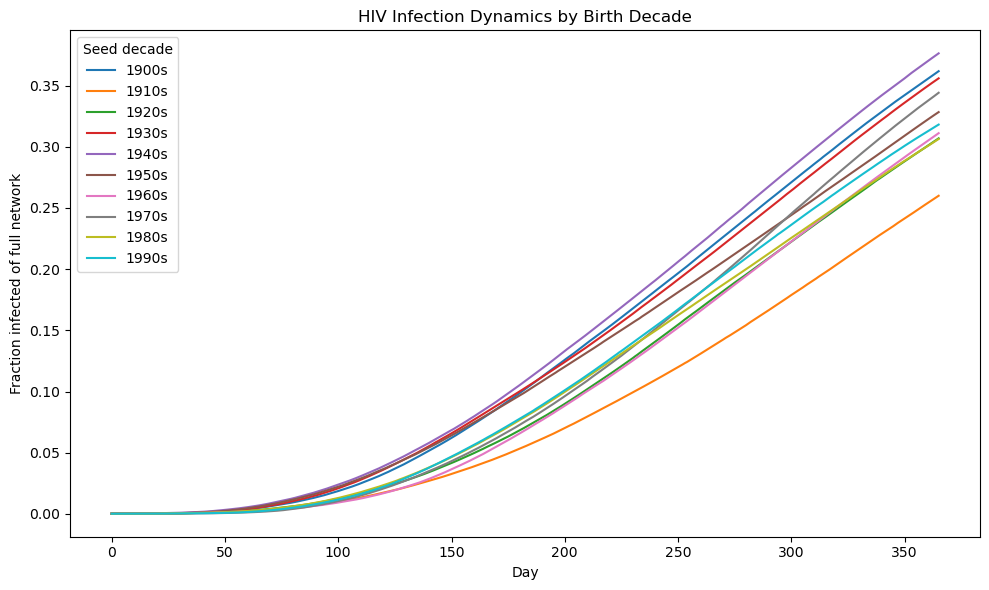

In [193]:
# ======================================================================
# GLOBAL INFECTION DYNAMICS BY SEED DECADE — NO CONFIDENCE BANDS
# ======================================================================

def run_seed_decade_with_CI(
    G,
    decade_nodes,
    p=0.001,  # HIV to AIDS R0 approx 2–5%
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    decade_mean = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[NO CI] Simulating (seed in {decade}s) with {len(nodes)} nodes...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)
        decade_mean[decade] = arr.mean(axis=0)

    return t_range, decade_mean


# ---- RUN WITHOUT CONFIDENCE BANDS ----
t_range, decade_mean = run_seed_decade_with_CI(
    G,
    decade_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# ---- PLOT (NO SHADING) ----
plt.figure(figsize=(10, 6))

for decade in sorted(decade_mean.keys()):
    plt.plot(
        t_range,
        decade_mean[decade],
        label=f"{decade}s"
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected of full network")
plt.title("HIV Infection Dynamics by Birth Decade")
plt.legend(title="Seed decade")
plt.tight_layout()
plt.savefig("YOB_InfectionDynamics_NoError.pdf", dpi=1000)
plt.show()

[CI] Simulating (seed in 1900s) with 28 nodes...
[CI] Simulating (seed in 1910s) with 81 nodes...
[CI] Simulating (seed in 1920s) with 157 nodes...
[CI] Simulating (seed in 1930s) with 294 nodes...
[CI] Simulating (seed in 1940s) with 807 nodes...
[CI] Simulating (seed in 1950s) with 2475 nodes...
[CI] Simulating (seed in 1960s) with 2571 nodes...
[CI] Simulating (seed in 1970s) with 798 nodes...
[CI] Simulating (seed in 1980s) with 331 nodes...
[CI] Simulating (seed in 1990s) with 116 nodes...


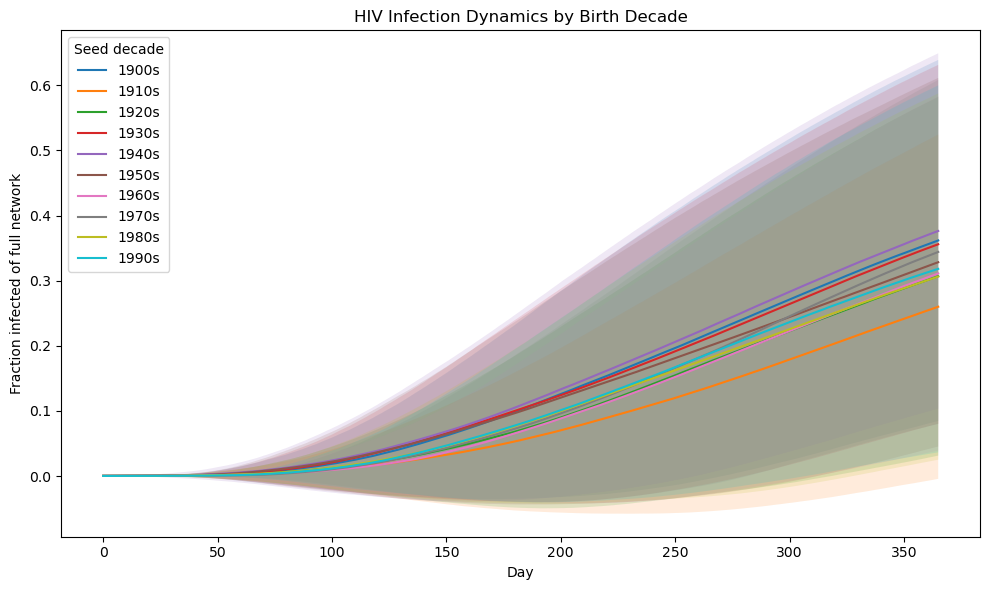

In [194]:
# ======================================================================
# CONFIDENCE BANDS FOR GLOBAL INFECTION DYNAMICS BY SEED DECADE
# ======================================================================

def run_seed_decade_with_CI(
    G,
    decade_nodes,
    p=0.001, #HIV to Aids R_0 between 2% and 5%
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    decade_mean = {}
    decade_std = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[CI] Simulating (seed in {decade}s) with {len(nodes)} nodes...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf)/N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)   # shape: (n_runs, tmax+1)

        decade_mean[decade] = arr.mean(axis=0)
        decade_std[decade] = arr.std(axis=0)

    return t_range, decade_mean, decade_std


# ---- RUN WITH CONFIDENCE BANDS ----
t_range, decade_mean, decade_std = run_seed_decade_with_CI(
    G,
    decade_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# ---- PLOT WITH BANDS ----
plt.figure(figsize=(10, 6))

for decade in sorted(decade_mean.keys()):
    mean_curve = decade_mean[decade]
    sd_curve   = decade_std[decade]

    plt.plot(t_range, mean_curve, label=f"{decade}s")
    plt.fill_between(
        t_range,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected of full network")
plt.title("HIV Infection Dynamics by Birth Decade")
plt.legend(title="Seed decade")
plt.tight_layout()
plt.savefig("YOB_InfectionDynamics_Error.pdf", dpi=1000)
plt.show()


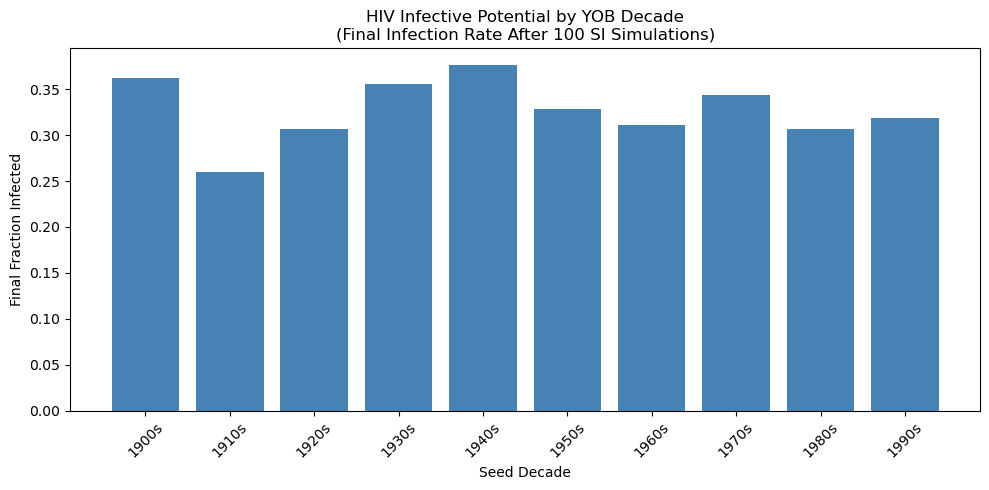

In [195]:
# ======================================================================
# BAR PLOT: INFECTIVE POTENTIAL BY SEED DECADE
# ======================================================================

final_values = {
    decade: decade_mean[decade][-1]   # last time point (t=365)
    for decade in decade_mean
}

# Sort by infective potential
sorted_decades = sorted(final_values.keys())
vals = [final_values[d] for d in sorted_decades]

plt.figure(figsize=(10, 5))
plt.bar([f"{d}s" for d in sorted_decades], vals, color="steelblue")
plt.xlabel("Seed Decade")
plt.ylabel("Final Fraction Infected")
plt.title("HIV Infective Potential by YOB Decade\n(Final Infection Rate After 100 SI Simulations)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("YOB_InfectionDynamics_BarGraph.pdf", dpi=1000)
plt.show()


In [196]:
import numpy as np
import random

def run_seed_group_with_CI(
    G,
    group_nodes,   # dict: label -> set(node_ids)
    p=0.01,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    """
    For each group label (e.g., decade, gender):
      - Seed infection in a node from that group
      - Run SI on the full graph G
      - Track fraction infected in the full network
      - Repeat n_runs times, return mean and std over runs
    """
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    group_mean = {}
    group_std  = {}

    for label, nodes in sorted(group_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[CI] Simulating (seed in {label}) with {len(nodes)} seed candidates...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)  # shape: (n_runs, tmax+1)
        group_mean[label] = arr.mean(axis=0)
        group_std[label]  = arr.std(axis=0)

    return t_range, group_mean, group_std


In [197]:
# Build gender-based node groups from df_1_clean and G
# SEX: 0 = Male, 1 = Female
nodes_in_G = set(G.nodes())
gender_nodes = {"Male": set(), "Female": set()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in nodes_in_G:
        continue

    sex = row["SEX"]
    if sex == 0:
        gender_nodes["Male"].add(rid)
    elif sex == 1:
        gender_nodes["Female"].add(rid)

print("Gender groups and counts:")
for label, nodes in gender_nodes.items():
    print(label, len(nodes))


Gender groups and counts:
Male 5899
Female 4736


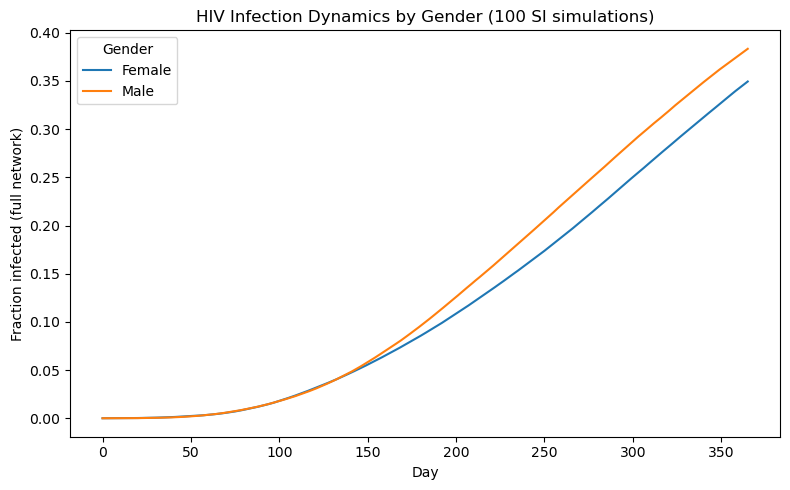

In [198]:
# Plot mean curves by gender (NO SD bands)
plt.figure(figsize=(8, 5))

for label in sorted(gender_mean.keys()):
    mean_curve = gender_mean[label]

    # plot mean only
    plt.plot(t_range_gender, mean_curve, label=label)

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("HIV Infection Dynamics by Gender (100 SI simulations)")
plt.legend(title="Gender")
plt.tight_layout()
plt.savefig("Gender_InfectionDynamics.pdf", dpi=1000)
plt.show()


[CI] Simulating (seed in Female) with 4736 seed candidates...
[CI] Simulating (seed in Male) with 5899 seed candidates...


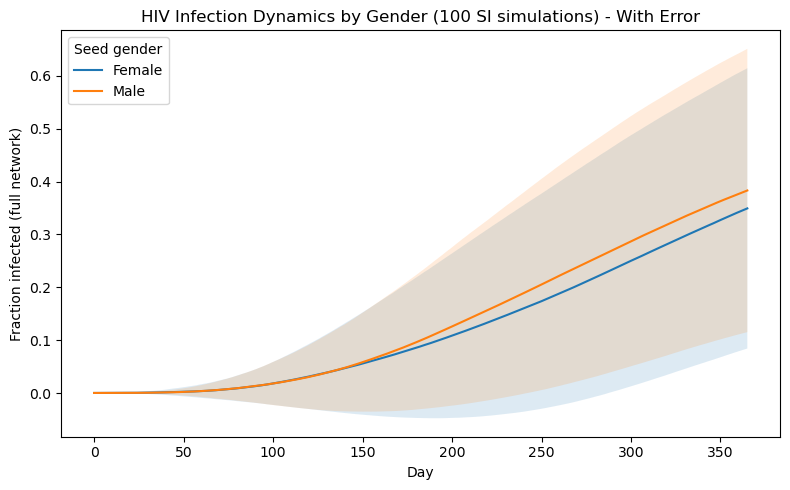

In [199]:
# Run SI with CI, but now by gender instead of decade
t_range_gender, gender_mean, gender_std = run_seed_group_with_CI(
    G,
    gender_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# Plot mean ± 1 SD curves by gender
plt.figure(figsize=(8, 5))

for label in sorted(gender_mean.keys()):
    mean_curve = gender_mean[label]
    sd_curve   = gender_std[label]

    plt.plot(t_range_gender, mean_curve, label=label)
    plt.fill_between(
        t_range_gender,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("HIV Infection Dynamics by Gender (100 SI simulations) - With Error")
plt.legend(title="Seed gender")
plt.tight_layout()
plt.savefig("Gender_InfectionDynamics_Error.pdf", dpi=1000)
plt.show()


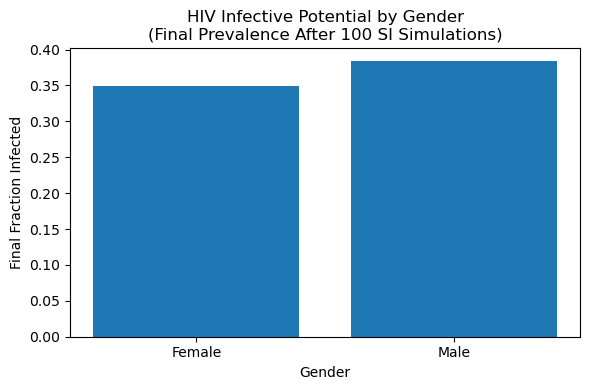

In [200]:
# =============================================
# Bar Plot: Infective Potential (Male vs Female)
# =============================================

# Extract final-day (t = 365) infection levels
gender_final = {
    label: gender_mean[label][-1]
    for label in gender_mean
}

labels = list(gender_final.keys())
values = [gender_final[label] for label in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel("Gender")
plt.ylabel("Final Fraction Infected")
plt.title("HIV Infective Potential by Gender\n(Final Prevalence After 100 SI Simulations)")
plt.tight_layout()
plt.savefig("Gender_InfectionDynamics_BarGraph.pdf", dpi=1000)
plt.show()


Race groups and counts:
American Indian: 10 nodes
Black: 4559 nodes
Asian / Pacific Islander: 5470 nodes
White: 2442 nodes
Other: 56 nodes
[CI] Simulating (seed in American Indian) with 10 seed candidates...
[CI] Simulating (seed in Asian / Pacific Islander) with 5470 seed candidates...
[CI] Simulating (seed in Black) with 4559 seed candidates...
[CI] Simulating (seed in Other) with 56 seed candidates...
[CI] Simulating (seed in White) with 2442 seed candidates...


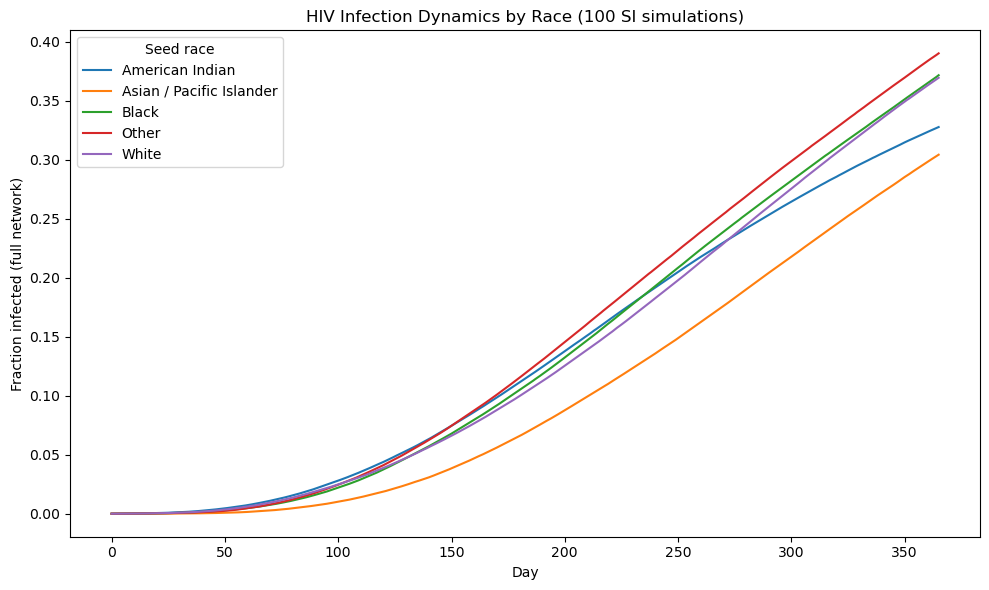

In [201]:
# ============================================
# 1. Build race-based groups (from codebook)
# ============================================
nodes_in_G = set(G.nodes())

race_code_to_label = {
    1: "American Indian",
    2: "Black",
    3: "Asian / Pacific Islander",
    4: "White",
    5: "Other"
}

# initialize group dict
race_nodes = {label: set() for label in race_code_to_label.values()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in nodes_in_G:
        continue

    race_code = row["RACE"]
    label = race_code_to_label.get(race_code, None)
    if label is not None:
        race_nodes[label].add(rid)

print("Race groups and counts:")
for label, nodes in race_nodes.items():
    print(f"{label}: {len(nodes)} nodes")


# ============================================
# 2. Run SI with CI, seeded by race
# ============================================
t_range_race, race_mean, race_std = run_seed_group_with_CI(
    G,
    race_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# ============================================
# 3. Plot mean curves by seed race (NO error bars)
# ============================================
plt.figure(figsize=(10, 6))

for label in sorted(race_mean.keys()):
    mean_curve = race_mean[label]
    plt.plot(t_range_race, mean_curve, label=label)

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("HIV Infection Dynamics by Race (100 SI simulations)")
plt.legend(title="Seed race")
plt.tight_layout()
plt.savefig("Race_InfectionDynamics.pdf", dpi=1000)
plt.show()

Race groups and counts:
American Indian: 10 nodes
Black: 4559 nodes
Asian / Pacific Islander: 5470 nodes
White: 2442 nodes
Other: 56 nodes
[CI] Simulating (seed in American Indian) with 10 seed candidates...
[CI] Simulating (seed in Asian / Pacific Islander) with 5470 seed candidates...
[CI] Simulating (seed in Black) with 4559 seed candidates...
[CI] Simulating (seed in Other) with 56 seed candidates...
[CI] Simulating (seed in White) with 2442 seed candidates...


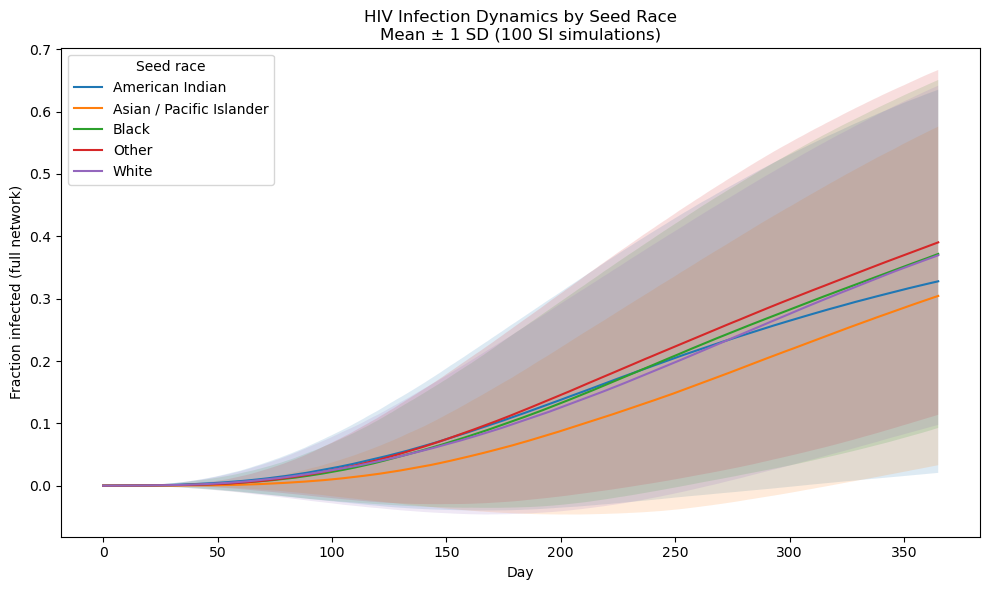

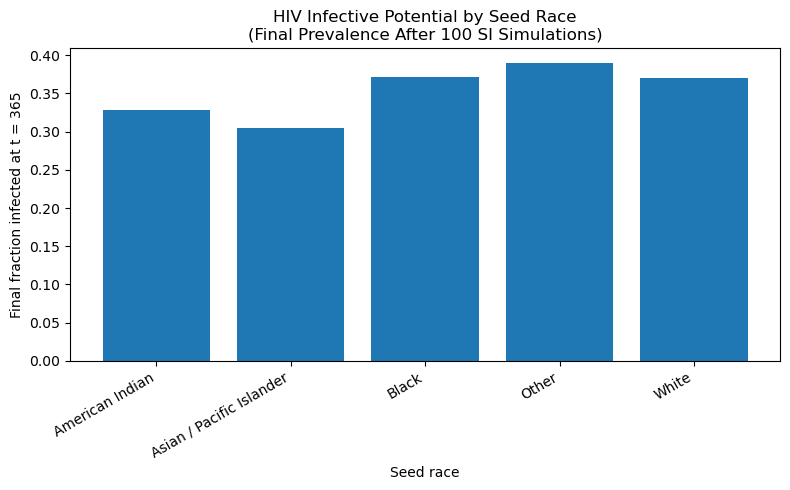

In [202]:
# ============================================
# 1. Build race-based groups (from codebook)
# ============================================
# Codebook for RACE:
# 1 = American Indian
# 2 = Black
# 3 = Asian / Pacific Islander
# 4 = White  (non-Black Hispanics already coded as White)
# 5 = Other
# -8, -9 etc. = missing / not asked / OOD

nodes_in_G = set(G.nodes())

race_code_to_label = {
    1: "American Indian",
    2: "Black",
    3: "Asian / Pacific Islander",
    4: "White",
    5: "Other"
}

# initialize group dict
race_nodes = {label: set() for label in race_code_to_label.values()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in nodes_in_G:
        continue

    race_code = row["RACE"]  # change to "race" if your column is lowercase
    label = race_code_to_label.get(race_code, None)
    if label is not None:
        race_nodes[label].add(rid)

print("Race groups and counts:")
for label, nodes in race_nodes.items():
    print(f"{label}: {len(nodes)} nodes")


# ============================================
# 2. Run SI with CI, seeded by race
# ============================================
t_range_race, race_mean, race_std = run_seed_group_with_CI(
    G,
    race_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# ============================================
# 3. Plot mean ± 1 SD curves by seed race
# ============================================
plt.figure(figsize=(10, 6))

for label in sorted(race_mean.keys()):
    mean_curve = race_mean[label]
    sd_curve   = race_std[label]

    plt.plot(t_range_race, mean_curve, label=label)
    plt.fill_between(
        t_range_race,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("HIV Infection Dynamics by Seed Race\nMean ± 1 SD (100 SI simulations)")
plt.legend(title="Seed race")
plt.tight_layout()
plt.savefig("Race_InfectionDynamics_Error.pdf", dpi=1000)
plt.show()


# ============================================
# 4. Bar plot: infective potential by race
# ============================================
race_final = {
    label: race_mean[label][-1]   # final-day prevalence
    for label in race_mean
}

labels = list(race_final.keys())
values = [race_final[label] for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.xlabel("Seed race")
plt.ylabel("Final fraction infected at t = 365")
plt.title("HIV Infective Potential by Seed Race\n(Final Prevalence After 100 SI Simulations)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("Race_InfectionDynamics_BarGraph.pdf", dpi=1000)
plt.show()


Saved figure to GenderNetwork.pdf


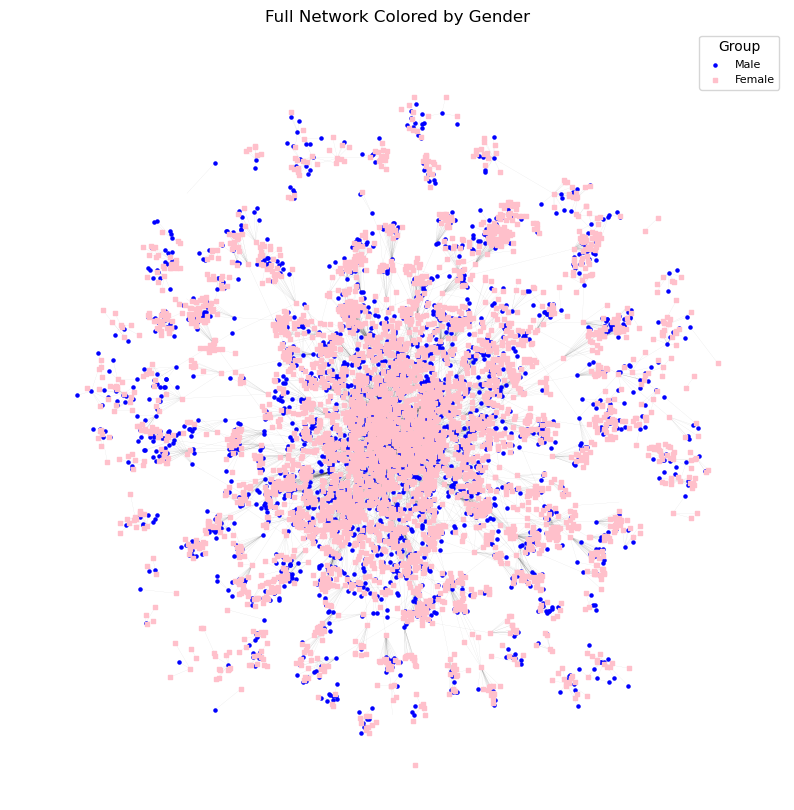

In [203]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_full_network_by_group(
        G,
        group_nodes,
        pos,
        title="",
        node_size=1,
        group_colors=None,
        group_shapes=None,
        save_path=None,  
    ):
    """
    Draw the full network, coloring / shaping nodes by group.
    group_nodes: dict {label: set/list of node IDs}
    pos: dict {node: (x, y)} with node positions
    """

    plt.figure(figsize=(10, 10))

    # Draw edges first
    nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.2)

    # Draw nodes by group
    for label, nodes in group_nodes.items():
        nodelist = list(nodes)
        if not nodelist:
            continue

        color = group_colors.get(label, "gray") if group_colors else "gray"
        shape = group_shapes.get(label, "o") if group_shapes else "o"

        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodelist,
            node_color=color,
            node_shape=shape,
            node_size=5,
            label=label,
        )

    plt.title(title)
    plt.axis("off")

    # Legend if groups provided
    if group_nodes:
        plt.legend(title="Group", scatterpoints=1, fontsize=8)

    if save_path is not None:
        plt.savefig(save_path, dpi=1000, bbox_inches="tight")
        print(f"Saved figure to {save_path}")

    plt.show()

custom_colors_gender = {
    "Male": "blue",
    "Female": "pink",
}

custom_shapes_gender = {
    "Male": "o",   # circle
    "Female": "s", # square
}

plot_full_network_by_group(
    G,
    gender_nodes,
    pos_full,
    title="Full Network Colored by Gender",
    node_size=1,
    group_colors=custom_colors_gender,
    group_shapes=custom_shapes_gender,
    save_path="GenderNetwork.pdf",   
)

Saved figure to RaceNetwork.pdf


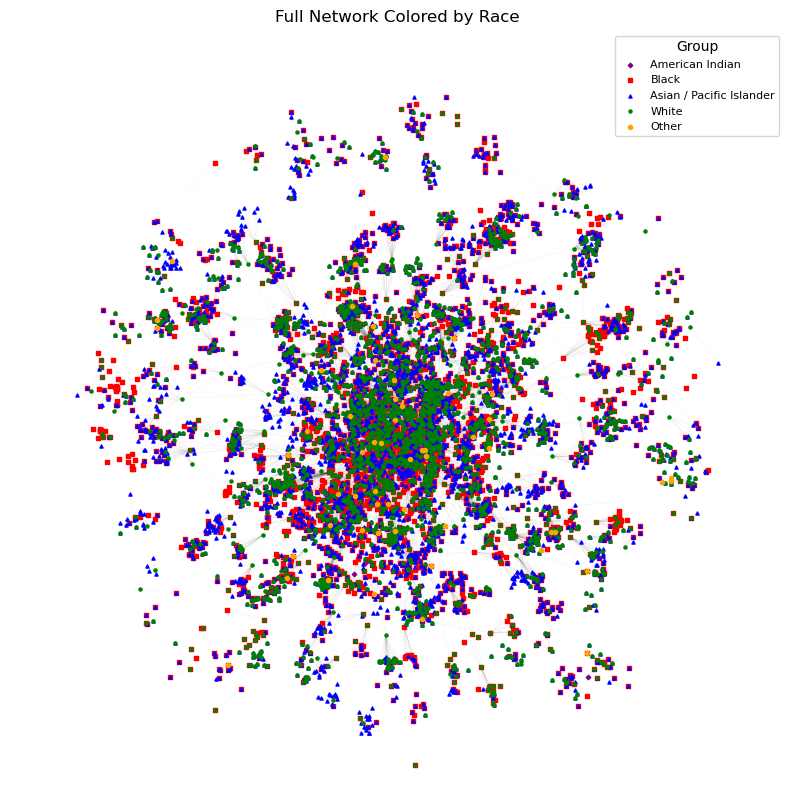

In [204]:
custom_colors_race = {
    "White": "green",
    "Black": "red",
    "Asian / Pacific Islander": "blue",
    "American Indian": "purple",
    "Other": "orange",
}

custom_shapes_race = {
    "White": "o",
    "Black": "s",
    "Asian / Pacific Islander": "^",
    "American Indian": "D",
    "Other": "P",
}

plot_full_network_by_group(
    G,
    race_nodes,
    pos_full,
    title="Full Network Colored by Race",
    node_size=2,
    group_colors=custom_colors_race,
    group_shapes=custom_shapes_race,
    save_path="RaceNetwork.pdf"  
)


Saved figure to YOBNetwork.pdf


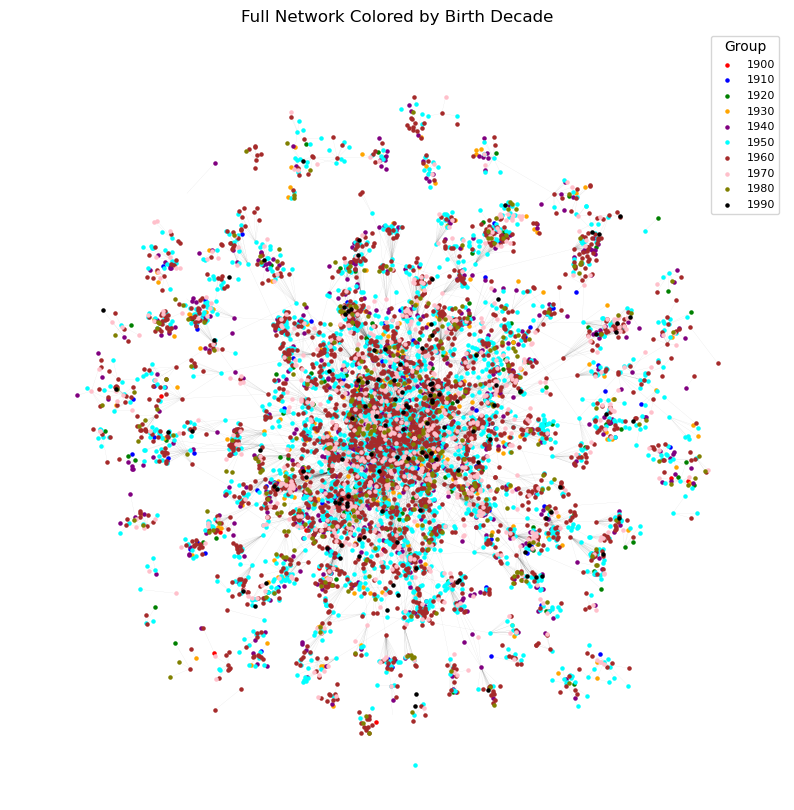

In [205]:
# ============================================
# CUSTOM COLORS + SHAPES FOR DECADES
# ============================================

custom_colors_decades = {
    1900: "red",
    1910: "blue",
    1920: "green",
    1930: "orange",
    1940: "purple",
    1950: "cyan",
    1960: "brown",
    1970: "pink",
    1980: "olive",
    1990: "black",
}

# All same shape (circles)
custom_shapes_decades = {dec: "o" for dec in custom_colors_decades}

# ============================================
# SORT decade_nodes HERE (this fixes the legend!)
# ============================================

decade_nodes = {dec: decade_nodes[dec] for dec in sorted(decade_nodes.keys())}

# ============================================
# PLOT FULL NETWORK COLORED BY DECADE
# ============================================

plot_full_network_by_group(
    G,
    decade_nodes,
    pos_full,
    title="Full Network Colored by Birth Decade",
    node_size=5,
    group_colors=custom_colors_decades,
    group_shapes=custom_shapes_decades,
    save_path="YOBNetwork.pdf"
)


/var/folders/wv/b5rtxhjd5v5011rxcmwqwzrm0000gn/T/ipykernel_31852/3710533514.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


Saved figure to YOBNetwork.pdf


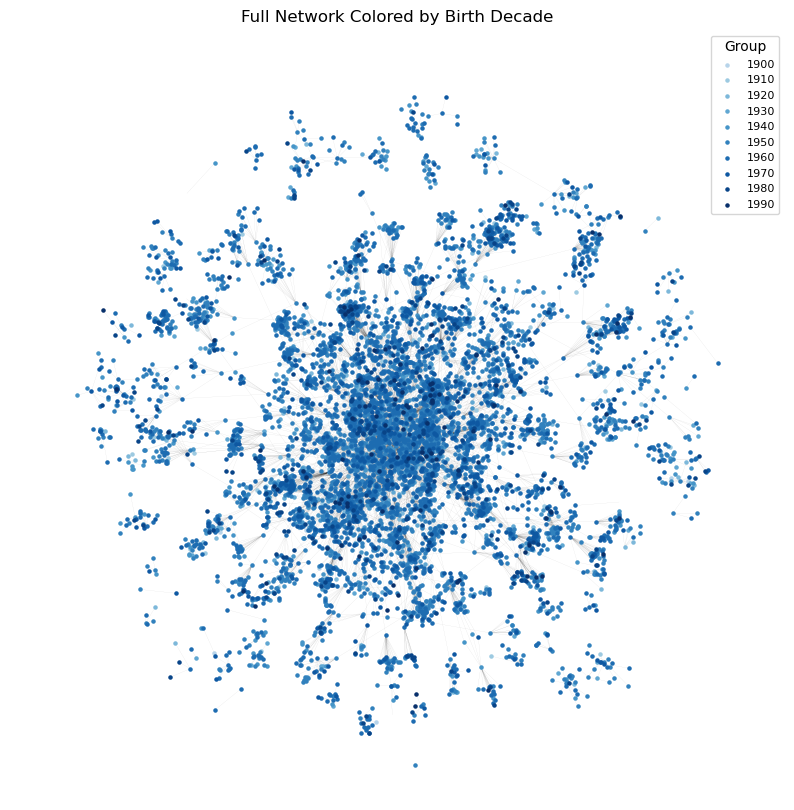

In [206]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# ============================================
# GENERATE NICER BLUE SHADES (avoid very light ones)
# We'll sample the top 70%–100% range of the colormap.
# ============================================

decades_sorted = sorted(decade_nodes.keys())
num_decades = len(decades_sorted)

# Sample between 0.30 → 1.00 rather than 0 → 1
color_positions = np.linspace(0.30, 1.00, num_decades)
blues = cm.get_cmap("Blues")

custom_colors_decades = {
    decade: mcolors.to_hex(blues(color_positions[i]))
    for i, decade in enumerate(decades_sorted)
}

# All same shape (circles)
custom_shapes_decades = {dec: "o" for dec in decades_sorted}

# ============================================
# SORT decade_nodes (fix legend order)
# ============================================

decade_nodes = {dec: decade_nodes[dec] for dec in decades_sorted}

# ============================================
# PLOT FULL NETWORK COLORED BY DECADE
# ============================================

plot_full_network_by_group(
    G,
    decade_nodes,
    pos_full,
    title="Full Network Colored by Birth Decade",
    node_size=5,
    group_colors=custom_colors_decades,
    group_shapes=custom_shapes_decades,
    save_path="YOBNetwork.pdf"
)


In [207]:
import numpy as np
from statistics import mean
import networkx as nx

# ---------------------------------------------------------
# 1. CENTRALITY MEASURES ON THE FULL NETWORK
# ---------------------------------------------------------
print("Computing centrality measures...")

deg_cent  = nx.degree_centrality(G)
close_cent = nx.closeness_centrality(G)
bet_cent  = nx.betweenness_centrality(G, normalized=True)
eig_cent  = nx.eigenvector_centrality(G, max_iter=2000)

# ---------------------------------------------------------
# 2. PRETTY TABLE SETUP
# ---------------------------------------------------------

decades_sorted = sorted(decade_nodes.keys())

header = (
    f"{'Decade':<8}"
    f"{'N_nodes':>10}"
    f"{'AvgDegree':>15}"
    f"{'AvgCloseness':>15}"
    f"{'AvgBetween':>15}"
    f"{'AvgEigen':>12}"
)

print(header)
print("-" * len(header))

# ---------------------------------------------------------
# 3. LOOP THROUGH DECADES AND PRINT CLEAN TABLE
# ---------------------------------------------------------

for decade in decades_sorted:
    group_nodes = [n for n in decade_nodes[decade] if n in G]

    if not group_nodes:
        continue

    avg_deg  = mean(deg_cent[n]   for n in group_nodes)
    avg_clo  = mean(close_cent[n] for n in group_nodes)
    avg_bet  = mean(bet_cent[n]   for n in group_nodes)
    avg_eig  = mean(eig_cent[n]   for n in group_nodes)

    print(
        f"{decade:<8}"
        f"{len(group_nodes):>10}"
        f"{avg_deg:>15.4f}"
        f"{avg_clo:>15.4f}"
        f"{avg_bet:>15.4f}"
        f"{avg_eig:>12.4f}"
    )


Computing centrality measures...
Decade     N_nodes      AvgDegree   AvgCloseness     AvgBetween    AvgEigen
---------------------------------------------------------------------------
1900            28         0.0001         0.1085         0.0000      0.0014
1910            81         0.0002         0.0909         0.0002      0.0013
1920           157         0.0002         0.1007         0.0001      0.0017
1930           294         0.0002         0.1029         0.0001      0.0018
1940           807         0.0003         0.1048         0.0006      0.0029
1950          2475         0.0004         0.1070         0.0006      0.0032
1960          2571         0.0003         0.1067         0.0005      0.0031
1970           798         0.0002         0.0996         0.0002      0.0019
1980           331         0.0001         0.0967         0.0000      0.0013
1990           116         0.0001         0.1029         0.0000      0.0015


In [208]:
# ---------------------------------------------------------
# BUILD SEX GROUPS (Male / Female)
# ---------------------------------------------------------
sex_nodes = {
    "Male": set(),
    "Female": set()
}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid in G:
        if row["SEX"] == 0:
            sex_nodes["Male"].add(rid)
        elif row["SEX"] == 1:
            sex_nodes["Female"].add(rid)

# ---------------------------------------------------------
# BUILD RACE GROUPS
# (same categories as your legend screenshot)
# ---------------------------------------------------------
race_nodes = {
    "American Indian": set(),
    "Black": set(),
    "Asian / Pacific Islander": set(),
    "White": set(),
    "Other": set(),
}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in G:
        continue

    race = row["RACE"]

    if race == 1:
        race_nodes["American Indian"].add(rid)
    elif race == 2:
        race_nodes["Black"].add(rid)
    elif race == 3:
        race_nodes["Asian / Pacific Islander"].add(rid)
    elif race == 4:
        race_nodes["White"].add(rid)
    elif race == 5:
        race_nodes["Other"].add(rid)


In [209]:
import numpy as np
from statistics import mean
import networkx as nx

# ---------------------------------------------------------
# CENTRALITY MEASURES ON THE FULL NETWORK
# (comment this block out if you've already computed them)
# ---------------------------------------------------------
print("Computing centrality measures (gender table)...")

deg_cent   = nx.degree_centrality(G)
close_cent = nx.closeness_centrality(G)
bet_cent   = nx.betweenness_centrality(G, normalized=True)
eig_cent   = nx.eigenvector_centrality(G, max_iter=2000)

# ---------------------------------------------------------
# PRETTY TABLE FOR GENDER GROUPS
# ---------------------------------------------------------
groups_sorted = sorted(sex_nodes.keys())  # e.g. ['Female', 'Male']

header = (
    f"{'Group':<12}"
    f"{'N_nodes':>10}"
    f"{'AvgDegree':>15}"
    f"{'AvgCloseness':>15}"
    f"{'AvgBetween':>15}"
    f"{'AvgEigen':>12}"
)

print(header)
print("-" * len(header))

for group in groups_sorted:
    group_nodes = [n for n in sex_nodes[group] if n in G]

    if not group_nodes:
        continue

    avg_deg  = mean(deg_cent[n]   for n in group_nodes)
    avg_clo  = mean(close_cent[n] for n in group_nodes)
    avg_bet  = mean(bet_cent[n]   for n in group_nodes)
    avg_eig  = mean(eig_cent[n]   for n in group_nodes)

    print(
        f"{group:<12}"
        f"{len(group_nodes):>10}"
        f"{avg_deg:>15.4f}"
        f"{avg_clo:>15.4f}"
        f"{avg_bet:>15.4f}"
        f"{avg_eig:>12.4f}"
    )


Computing centrality measures (gender table)...
Group          N_nodes      AvgDegree   AvgCloseness     AvgBetween    AvgEigen
-------------------------------------------------------------------------------
Female            4736         0.0003         0.1049         0.0005      0.0030
Male              5899         0.0003         0.1066         0.0005      0.0029


In [210]:
import numpy as np
from statistics import mean
import networkx as nx

print("Computing centrality measures (race)...")

deg_cent   = nx.degree_centrality(G)
close_cent = nx.closeness_centrality(G)
bet_cent   = nx.betweenness_centrality(G, normalized=True)
eig_cent   = nx.eigenvector_centrality(G, max_iter=2000)

groups_sorted = [
    "American Indian",
    "Black",
    "Asian / Pacific Islander",
    "White",
    "Other",
]

header = (
    f"{'Group':<24}"
    f"{'N_nodes':>10}"
    f"{'AvgDegree':>15}"
    f"{'AvgCloseness':>15}"
    f"{'AvgBetween':>15}"
    f"{'AvgEigen':>12}"
)

print(header)
print("-" * len(header))

for group in groups_sorted:
    group_nodes = [n for n in race_nodes[group] if n in G]
    if not group_nodes:
        continue

    avg_deg  = mean(deg_cent[n]   for n in group_nodes)
    avg_clo  = mean(close_cent[n] for n in group_nodes)
    avg_bet  = mean(bet_cent[n]   for n in group_nodes)
    avg_eig  = mean(eig_cent[n]   for n in group_nodes)

    print(
        f"{group:<24}"
        f"{len(group_nodes):>10}"
        f"{avg_deg:>15.4f}"
        f"{avg_clo:>15.4f}"
        f"{avg_bet:>15.4f}"
        f"{avg_eig:>12.4f}"
    )


Computing centrality measures (race)...
Group                      N_nodes      AvgDegree   AvgCloseness     AvgBetween    AvgEigen
-------------------------------------------------------------------------------------------
American Indian                 10         0.0017         0.0722         0.0034      0.0073
Black                         4559         0.0003         0.1094         0.0006      0.0039
Asian / Pacific Islander      5470         0.0001         0.1004         0.0001      0.0013
White                         2442         0.0006         0.1046         0.0011      0.0039
Other                           56         0.0008         0.1115         0.0015      0.0055



**********************************************************************
THIS IS WHERE WE BEGIN THE NEW ANALYSIS USING FEEDBACK FROM DR. LANDRY 
**********************************************************************

Using orientation column: ORIENT

Orientation mix among SEX-network nodes (valid orient only):
  hetero: 576 (0.772)
  homo:   111 (0.149)
  bi:     59 (0.079)

Assigned per-act risks:
  p_het  (vaginal avg) = 0.000600
  p_homo (anal)        = 0.017000
  p_bi   (50/50 mix)   = 0.008800

FINAL weighted p_sex = 0.003689
[SEX SI] Simulating (seed in 1900s) with 30 candidate seeds...
[SEX SI] Simulating (seed in 1910s) with 41 candidate seeds...
[SEX SI] Simulating (seed in 1920s) with 163 candidate seeds...
[SEX SI] Simulating (seed in 1930s) with 304 candidate seeds...
[SEX SI] Simulating (seed in 1940s) with 748 candidate seeds...
[SEX SI] Simulating (seed in 1950s) with 2248 candidate seeds...
[SEX SI] Simulating (seed in 1960s) with 2867 candidate seeds...
[SEX SI] Simulating (seed in 1970s) with 915 candidate seeds...
[SEX SI] Simulating (seed in 1980s) with 255 candidate seeds...
[SEX SI] Simulating (seed in 1990s) with 16 candidate seeds...


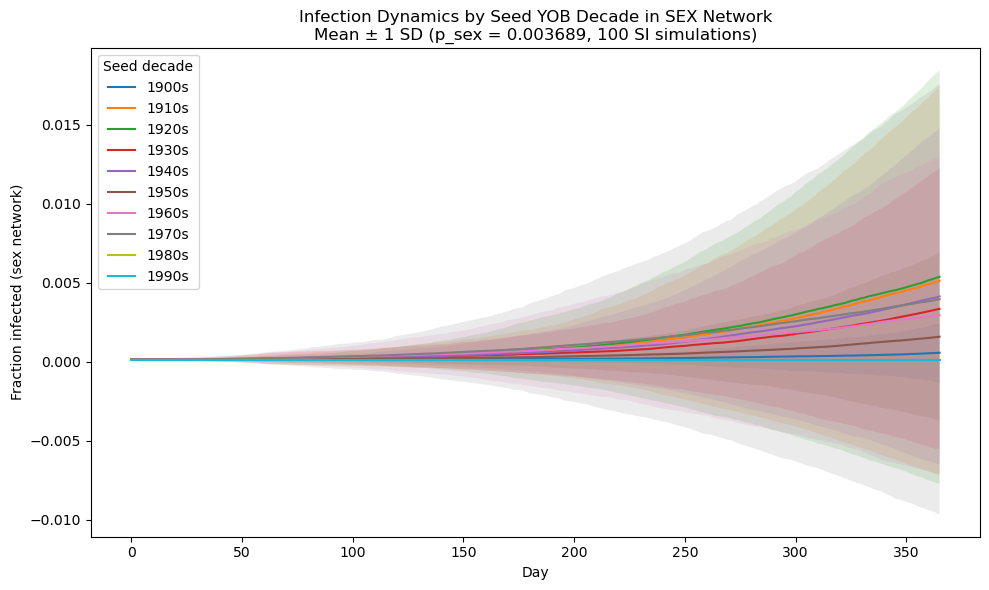

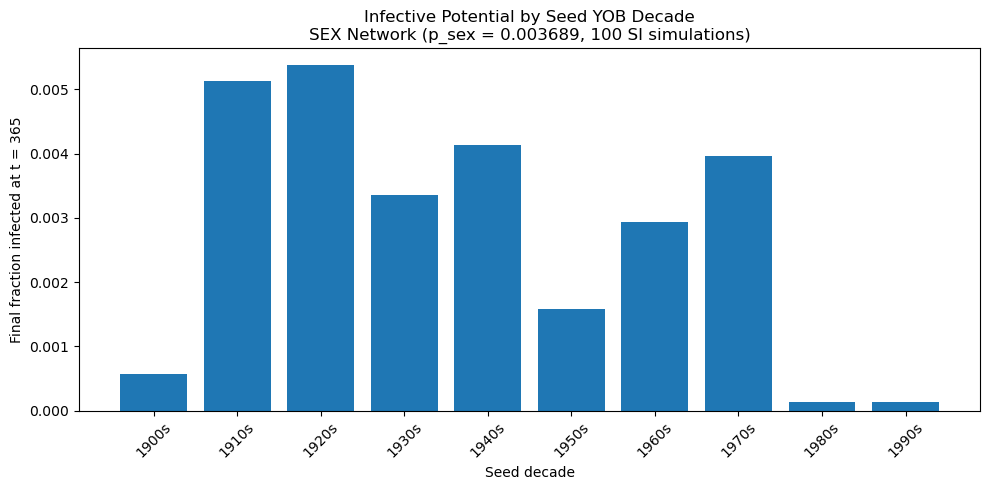

In [ ]:
# ======================================================================
# SI CONTAGION ON SEX NETWORK, WITH ORIENTATION-BASED p_sex
# ======================================================================

import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------------------------------------------------------------
# 1. Find the orientation column in df_1_clean
#    Codebook: ORIENT (0=het, 1=homo, 2=bi, -8/-9/3 missing)
# ---------------------------------------------------------------
orient_candidates = [c for c in df_1_clean.columns if c.lower().startswith("orient")]
if not orient_candidates:
    raise ValueError(
        "Could not find an orientation column in df_1_clean "
        "(expected something like 'orient' or 'ORIENT')."
    )

orient_col = orient_candidates[0]
print(f"Using orientation column: {orient_col}")

# ---------------------------------------------------------------
# 2. Compute orientation mix among nodes in the SEX network
# ---------------------------------------------------------------
sex_nodes = set(G_sex.nodes())

counts = {"het": 0, "homo": 0, "bi": 0}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in sex_nodes:
        continue

    orient = row[orient_col]

    # Codebook: 0=heterosexual, 1=homosexual, 2=bisexual, -8/-9/3=missing/other
    if orient == 0:
        counts["het"] += 1
    elif orient == 1:
        counts["homo"] += 1
    elif orient == 2:
        counts["bi"] += 1
    else:
        # ignore missing/undefined
        pass

total_oriented = counts["het"] + counts["homo"] + counts["bi"]
if total_oriented == 0:
    raise ValueError("No nodes in the sex network have valid orientation codes.")

w_het  = counts["het"]  / total_oriented
w_homo = counts["homo"] / total_oriented
w_bi   = counts["bi"]   / total_oriented

print("\nOrientation mix among SEX-network nodes (valid orient only):")
print(f"  hetero: {counts['het']} ({w_het:.3f})")
print(f"  homo:   {counts['homo']} ({w_homo:.3f})")
print(f"  bi:     {counts['bi']} ({w_bi:.3f})")

# ---------------------------------------------------------------
# 3. Per-orientation transmission risks (per act)
# ---------------------------------------------------------------
p_MF  = 0.0008   # male -> female vaginal
p_FM  = 0.0004   # female -> male vaginal
p_het = (p_MF + p_FM) / 2.0   # avg vaginal risk = 0.0006

p_homo = 0.017  # receptive anal (MSM)

# Bisexual: higher risk by mixing vaginal + anal exposure
# Here we choose 50% vaginal, 50% anal (you can tweak weights later).
p_bi = 0.5 * p_het + 0.5 * p_homo   # ≈ 0.0083

print(f"\nAssigned per-act risks:")
print(f"  p_het  (vaginal avg) = {p_het:.6f}")
print(f"  p_homo (anal)        = {p_homo:.6f}")
print(f"  p_bi   (50/50 mix)   = {p_bi:.6f}")

# ---------------------------------------------------------------
# 4. Compute weighted p_sex for this network
# ---------------------------------------------------------------
p_sex = w_het * p_het + w_homo * p_homo + w_bi * p_bi
print(f"\nFINAL weighted p_sex = {p_sex:.6f}")

# ---------------------------------------------------------------
# 5. SI contagion helpers (same SI logic as before)
# ---------------------------------------------------------------
def SIContagion_decade(G, initial_infected, p, tmax):
    """
    Simple SI model on an undirected graph.

    infected_over_time[t] = set of infected nodes at time t
    (length tmax + 1, including t=0)
    """
    infected = set(initial_infected)
    infected_over_time = [set(infected)]  # t = 0

    for _ in range(tmax):
        new_infected = set(infected)
        for u in infected:
            for v in G.neighbors(u):
                if v not in infected and random.random() < p:
                    new_infected.add(v)
        infected = new_infected
        infected_over_time.append(set(infected))

    return infected_over_time


def run_seed_decade_with_CI(
    G,
    decade_nodes,
    p,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    """
    For each YOB decade:
      - Seed infection in a node from that decade
      - Run SI on full graph G
      - Measure global prevalence over time
    Returns:
      t_range, decade_mean, decade_std
    """
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    decade_mean = {}
    decade_std = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[SEX SI] Simulating (seed in {decade}s) with {len(nodes)} candidate seeds...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)  # shape (n_runs, tmax+1)
        decade_mean[decade] = arr.mean(axis=0)
        decade_std[decade]  = arr.std(axis=0)

    return t_range, decade_mean, decade_std

# ---------------------------------------------------------------
# 6. Run SI on SEX network by decade with this p_sex
# ---------------------------------------------------------------
t_range_sex, decade_mean_sex, decade_std_sex = run_seed_decade_with_CI(
    G_sex,
    decade_nodes_sex,
    p=p_sex,
    tmax=365,
    n_runs=100,
    rng_seed=42
)

# ---------------------------------------------------------------
# 7. Plot I(t) with confidence bands (SEX network)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for decade in sorted(decade_mean_sex.keys()):
    mean_curve = decade_mean_sex[decade]
    sd_curve   = decade_std_sex[decade]

    plt.plot(t_range_sex, mean_curve, label=f"{decade}s")
    plt.fill_between(
        t_range_sex,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (sex network)")
plt.title(
    "Infection Dynamics by Seed YOB Decade in SEX Network\n"
    f"Mean ± 1 SD (p_sex = {p_sex:.4g}, 100 SI simulations)"
)
plt.legend(title="Seed decade")
plt.savefig("YOBCurve_InfectivePotentialSEX.pdf", dpi=1000)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 8. Bar plot: infective potential by decade (SEX network)
# ---------------------------------------------------------------
final_values_sex = {
    decade: decade_mean_sex[decade][-1]
    for decade in decade_mean_sex
}
sorted_decades_sex = sorted(final_values_sex.keys())
vals_sex = [final_values_sex[d] for d in sorted_decades_sex]

plt.figure(figsize=(10, 5))
plt.bar([f"{d}s" for d in sorted_decades_sex], vals_sex)
plt.xlabel("Seed decade")
plt.ylabel("Final fraction infected at t = 365")
plt.title(
    "Infective Potential by Seed YOB Decade\n"
    f"SEX Network (p_sex = {p_sex:.4g}, 100 SI simulations)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("YOB_BarGraph_InfectivePotentialSEX.pdf", dpi=1000)
plt.show()


[DRUG SI] Simulating (seed in 1900s) with 30 candidate seeds...
[DRUG SI] Simulating (seed in 1910s) with 41 candidate seeds...
[DRUG SI] Simulating (seed in 1920s) with 163 candidate seeds...
[DRUG SI] Simulating (seed in 1930s) with 304 candidate seeds...
[DRUG SI] Simulating (seed in 1940s) with 748 candidate seeds...
[DRUG SI] Simulating (seed in 1950s) with 2248 candidate seeds...
[DRUG SI] Simulating (seed in 1960s) with 2867 candidate seeds...
[DRUG SI] Simulating (seed in 1970s) with 915 candidate seeds...
[DRUG SI] Simulating (seed in 1980s) with 255 candidate seeds...
[DRUG SI] Simulating (seed in 1990s) with 16 candidate seeds...


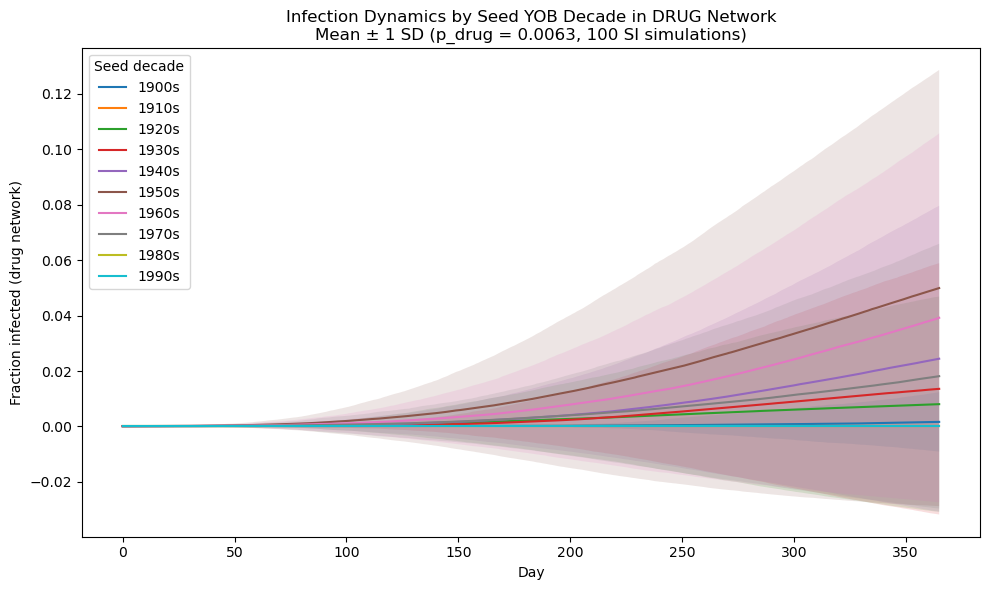

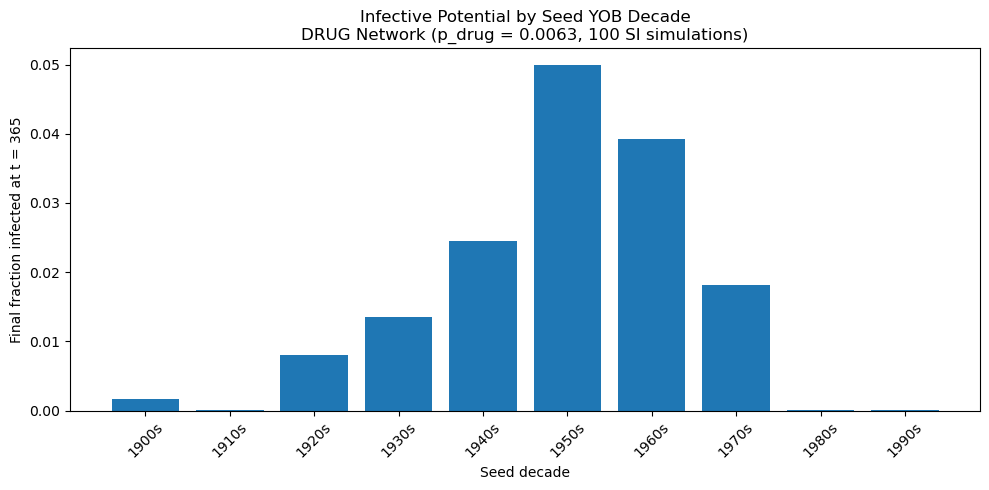

In [216]:
# ======================================================================
# SI CONTAGION ON DRUG NETWORK WITH FIXED p_drug = 0.0063
# ======================================================================

# Fixed per-contact transmission probability for DRUG network
p_drug = 0.0063

# ---------------------------------------------------------------
# 1. Helper: run SI with CIs on DRUG network by YOB decade
#    (reuses SIContagion_decade defined earlier)
# ---------------------------------------------------------------
def run_seed_decade_with_CI_drug(
    G,
    decade_nodes,
    p,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    """
    For each YOB decade:
      - Seed infection in a node from that decade
      - Run SI on full graph G (drug network)
      - Measure global prevalence over time
    Returns:
      t_range, decade_mean, decade_std
    """
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    decade_mean = {}
    decade_std = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[DRUG SI] Simulating (seed in {decade}s) with {len(nodes)} candidate seeds...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)  # shape (n_runs, tmax+1)
        decade_mean[decade] = arr.mean(axis=0)
        decade_std[decade]  = arr.std(axis=0)

    return t_range, decade_mean, decade_std


# ---------------------------------------------------------------
# 2. Run SI on DRUG network by decade with p_drug
# ---------------------------------------------------------------
t_range_drug, decade_mean_drug, decade_std_drug = run_seed_decade_with_CI_drug(
    G_drug,
    decade_nodes_drug,
    p=p_drug,
    tmax=365,
    n_runs=100,
    rng_seed=42
)

# ---------------------------------------------------------------
# 3. Plot I(t) with confidence bands (DRUG network)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for decade in sorted(decade_mean_drug.keys()):
    mean_curve = decade_mean_drug[decade]
    sd_curve   = decade_std_drug[decade]

    plt.plot(t_range_drug, mean_curve, label=f"{decade}s")
    plt.fill_between(
        t_range_drug,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (drug network)")
plt.title(
    "Infection Dynamics by Seed YOB Decade in DRUG Network\n"
    f"Mean ± 1 SD (p_drug = {p_drug:.4g}, 100 SI simulations)"
)
plt.legend(title="Seed decade")
plt.tight_layout()
plt.savefig("YOBCurve_InfectivePotentialDRUG.pdf", dpi=1000)
plt.show()

# ---------------------------------------------------------------
# 4. Bar plot: infective potential by decade (DRUG network)
# ---------------------------------------------------------------
final_values_drug = {
    decade: decade_mean_drug[decade][-1]
    for decade in decade_mean_drug
}
sorted_decades_drug = sorted(final_values_drug.keys())
vals_drug = [final_values_drug[d] for d in sorted_decades_drug]

plt.figure(figsize=(10, 5))
plt.bar([f"{d}s" for d in sorted_decades_drug], vals_drug)
plt.xlabel("Seed decade")
plt.ylabel("Final fraction infected at t = 365")
plt.title(
    "Infective Potential by Seed YOB Decade\n"
    f"DRUG Network (p_drug = {p_drug:.4g}, 100 SI simulations)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("YOB_BarGraph_InfectivePotentialDRUG.pdf", dpi=1000)
plt.show()


Using gender column for SEX network: SEX

SEX network gender counts:
  Male: 4711
  Female: 5851
[SEX SI] Simulating (seed in Male) with 4711 candidate seeds...
[SEX SI] Simulating (seed in Female) with 5851 candidate seeds...


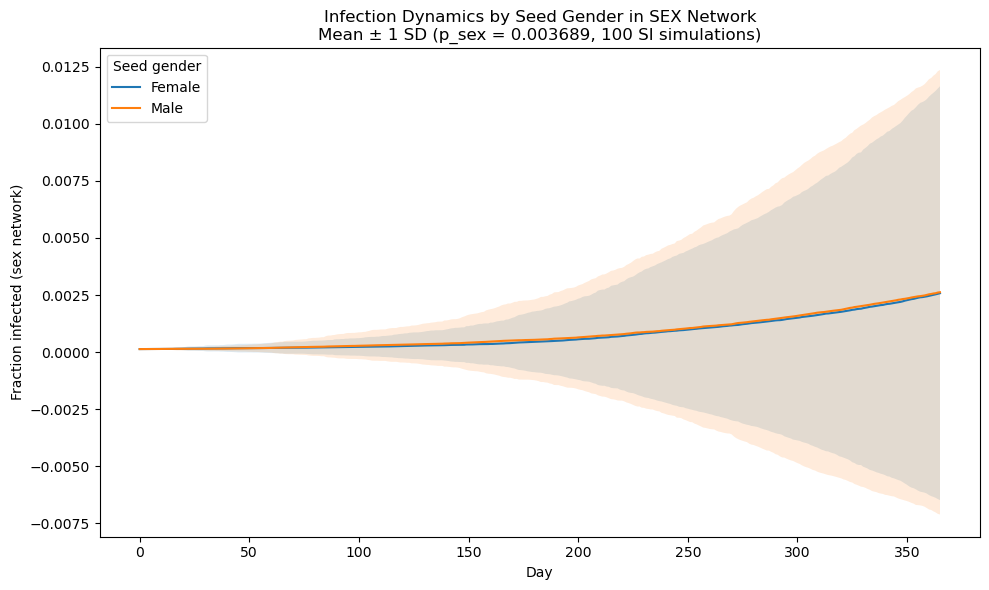

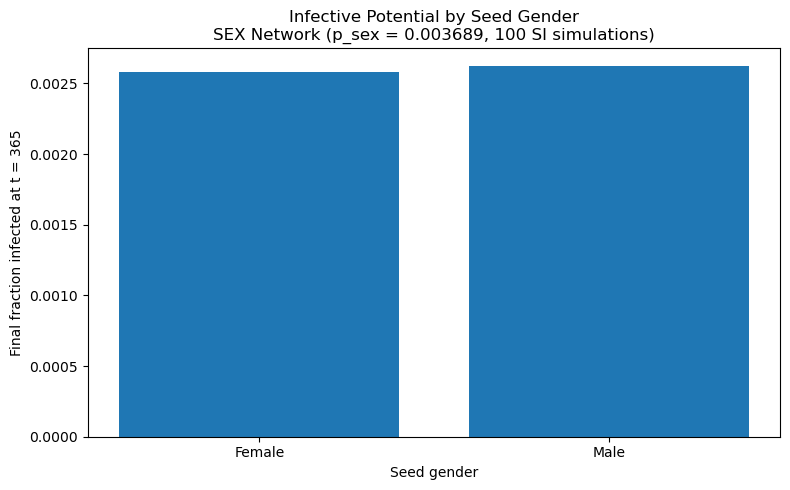

In [226]:
# ======================================================================
# SI CONTAGION ON SEX NETWORK BY GENDER (using p_sex)
# ======================================================================

# ---------------------------------------------------------------
# 1. Build gender → node mapping for the SEX network
# ---------------------------------------------------------------
gender_col_candidates = [c for c in df_1_clean.columns if c.lower().startswith("sex")]
if not gender_col_candidates:
    raise ValueError("Could not find a gender/sex column in df_1_clean.")

gender_col = gender_col_candidates[0]
print(f"Using gender column for SEX network: {gender_col}")

sex_nodes = set(G_sex.nodes())
gender_nodes_sex = {"Male": set(), "Female": set()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in sex_nodes:
        continue

    g = row[gender_col]
    if g == 1:
        gender_nodes_sex["Male"].add(rid)
    elif g == 0:
        gender_nodes_sex["Female"].add(rid)

print("\nSEX network gender counts:")
for g, nodes in gender_nodes_sex.items():
    print(f"  {g}: {len(nodes)}")

# ---------------------------------------------------------------
# 2. Helper: run SI with CIs on SEX network by gender
# ---------------------------------------------------------------
def run_gender_with_CI_sex(
    G,
    gender_nodes,
    p,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    gender_mean = {}
    gender_std = {}

    for gender, nodes in gender_nodes.items():
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[SEX SI] Simulating (seed in {gender}) with {len(nodes)} candidate seeds...")

        all_runs = []
        for _ in range(n_runs):
            seed = random.choice(nodes)
            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )
            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)
        gender_mean[gender] = arr.mean(axis=0)
        gender_std[gender]  = arr.std(axis=0)

    return t_range, gender_mean, gender_std

# ---------------------------------------------------------------
# 3. Run SI on SEX network by gender
# ---------------------------------------------------------------
t_gender_sex, gender_mean_sex, gender_std_sex = run_gender_with_CI_sex(
    G_sex,
    gender_nodes_sex,
    p=p_sex,
    tmax=365,
    n_runs=100,
    rng_seed=42
)

# ---------------------------------------------------------------
# 4. Plot I(t) with confidence bands (SEX network, by gender)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for gender in sorted(gender_mean_sex.keys()):
    mean_curve = gender_mean_sex[gender]
    sd_curve   = gender_std_sex[gender]

    plt.plot(t_gender_sex, mean_curve, label=gender)
    plt.fill_between(
        t_gender_sex,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (sex network)")
plt.title(
    "Infection Dynamics by Seed Gender in SEX Network\n"
    f"Mean ± 1 SD (p_sex = {p_sex:.4g}, 100 SI simulations)"
)
plt.legend(title="Seed gender")
plt.tight_layout()
plt.savefig("GenderCurve_InfectivePotentialSEX.pdf", dpi=1000)
plt.show()

# ---------------------------------------------------------------
# 5. Bar plot: infective potential by gender (SEX network)
# ---------------------------------------------------------------
final_values_gender_sex = {
    gender: gender_mean_sex[gender][-1]
    for gender in gender_mean_sex
}

sorted_genders_sex = list(sorted(final_values_gender_sex.keys()))
vals_gender_sex = [final_values_gender_sex[g] for g in sorted_genders_sex]

plt.figure(figsize=(8, 5))
plt.bar(sorted_genders_sex, vals_gender_sex)
plt.xlabel("Seed gender")
plt.ylabel("Final fraction infected at t = 365")
plt.title(
    "Infective Potential by Seed Gender\n"
    f"SEX Network (p_sex = {p_sex:.4g}, 100 SI simulations)"
)
plt.tight_layout()
plt.savefig("Gender_BarGraph_InfectivePotentialSEX.pdf", dpi=1000)
plt.show()


Using gender column for DRUG network: SEX

DRUG network gender counts:
  Male: 4711
  Female: 5851
[DRUG SI] Simulating (seed in Male) with 4711 candidate seeds...
[DRUG SI] Simulating (seed in Female) with 5851 candidate seeds...


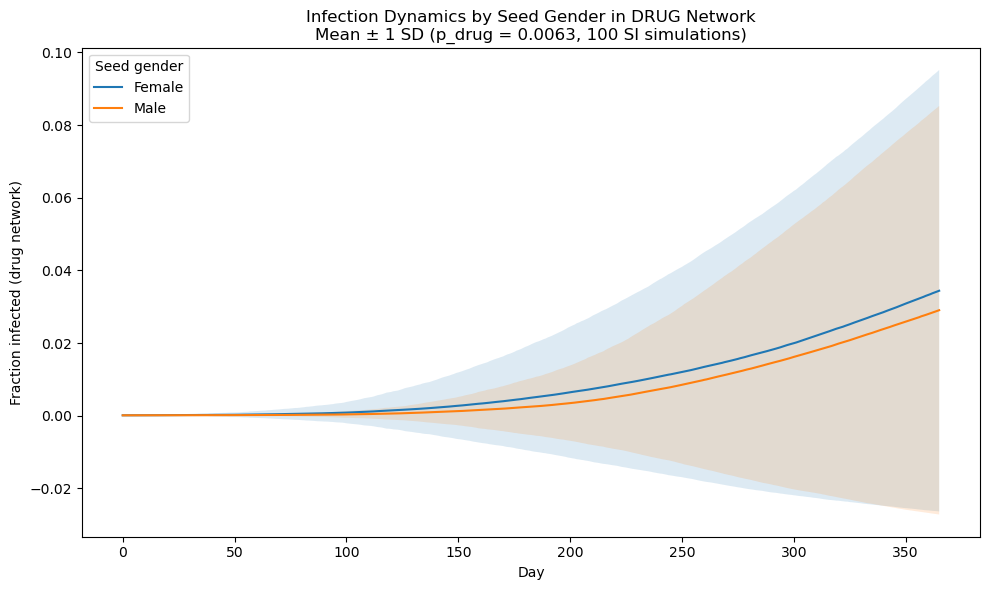

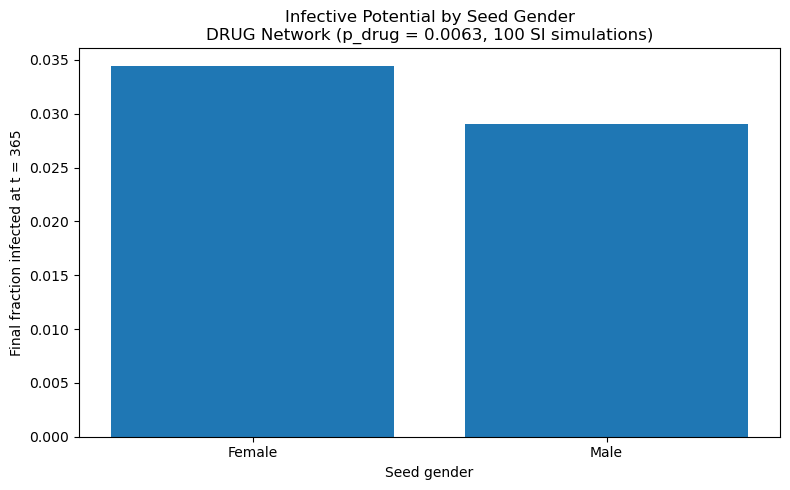

In [227]:
# ======================================================================
# SI CONTAGION ON DRUG NETWORK BY GENDER (using p_drug)
# ======================================================================

# ---------------------------------------------------------------
# 1. Build gender → node mapping for the DRUG network
# ---------------------------------------------------------------
gender_col_candidates = [c for c in df_1_clean.columns if c.lower().startswith("sex")]
if not gender_col_candidates:
    raise ValueError("Could not find a gender/sex column in df_1_clean.")

gender_col = gender_col_candidates[0]
print(f"Using gender column for DRUG network: {gender_col}")

drug_nodes = set(G_drug.nodes())
gender_nodes_drug = {"Male": set(), "Female": set()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in drug_nodes:
        continue

    g = row[gender_col]
    if g == 1:
        gender_nodes_drug["Male"].add(rid)
    elif g == 0:
        gender_nodes_drug["Female"].add(rid)

print("\nDRUG network gender counts:")
for g, nodes in gender_nodes_drug.items():
    print(f"  {g}: {len(nodes)}")

# ---------------------------------------------------------------
# 2. Helper: run SI with CIs on DRUG network by gender
# ---------------------------------------------------------------
def run_gender_with_CI_drug(
    G,
    gender_nodes,
    p,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    gender_mean = {}
    gender_std = {}

    for gender, nodes in gender_nodes.items():
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[DRUG SI] Simulating (seed in {gender}) with {len(nodes)} candidate seeds...")

        all_runs = []
        for _ in range(n_runs):
            seed = random.choice(nodes)
            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )
            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)
        gender_mean[gender] = arr.mean(axis=0)
        gender_std[gender]  = arr.std(axis=0)

    return t_range, gender_mean, gender_std

# ---------------------------------------------------------------
# 3. Run SI on DRUG network by gender
# ---------------------------------------------------------------
t_gender_drug, gender_mean_drug, gender_std_drug = run_gender_with_CI_drug(
    G_drug,
    gender_nodes_drug,
    p=p_drug,
    tmax=365,
    n_runs=100,
    rng_seed=42
)

# ---------------------------------------------------------------
# 4. Plot I(t) with confidence bands (DRUG network, by gender)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for gender in sorted(gender_mean_drug.keys()):
    mean_curve = gender_mean_drug[gender]
    sd_curve   = gender_std_drug[gender]

    plt.plot(t_gender_drug, mean_curve, label=gender)
    plt.fill_between(
        t_gender_drug,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (drug network)")
plt.title(
    "Infection Dynamics by Seed Gender in DRUG Network\n"
    f"Mean ± 1 SD (p_drug = {p_drug:.4g}, 100 SI simulations)"
)
plt.legend(title="Seed gender")
plt.tight_layout()
plt.savefig("GenderCurve_InfectivePotentialDRUG.pdf", dpi=1000)
plt.show()

# ---------------------------------------------------------------
# 5. Bar plot: infective potential by gender (DRUG network)
# ---------------------------------------------------------------
final_values_gender_drug = {
    gender: gender_mean_drug[gender][-1]
    for gender in gender_mean_drug
}

sorted_genders_drug = list(sorted(final_values_gender_drug.keys()))
vals_gender_drug = [final_values_gender_drug[g] for g in sorted_genders_drug]

plt.figure(figsize=(8, 5))
plt.bar(sorted_genders_drug, vals_gender_drug)
plt.xlabel("Seed gender")
plt.ylabel("Final fraction infected at t = 365")
plt.title(
    "Infective Potential by Seed Gender\n"
    f"DRUG Network (p_drug = {p_drug:.4g}, 100 SI simulations)"
)
plt.tight_layout()
plt.savefig("Gender_BarGraph_InfectivePotentialDRUG.pdf", dpi=1000)
plt.show()


Using race column for SEX network: RACE

SEX network race counts:
  White: 10
  Black: 4509
  American Indian: 5469
  Asian / Pacific Islander: 2422
  Other: 55
[SEX SI] Simulating (seed in White) with 10 candidate seeds...
[SEX SI] Simulating (seed in Black) with 4509 candidate seeds...
[SEX SI] Simulating (seed in American Indian) with 5469 candidate seeds...
[SEX SI] Simulating (seed in Asian / Pacific Islander) with 2422 candidate seeds...
[SEX SI] Simulating (seed in Other) with 55 candidate seeds...


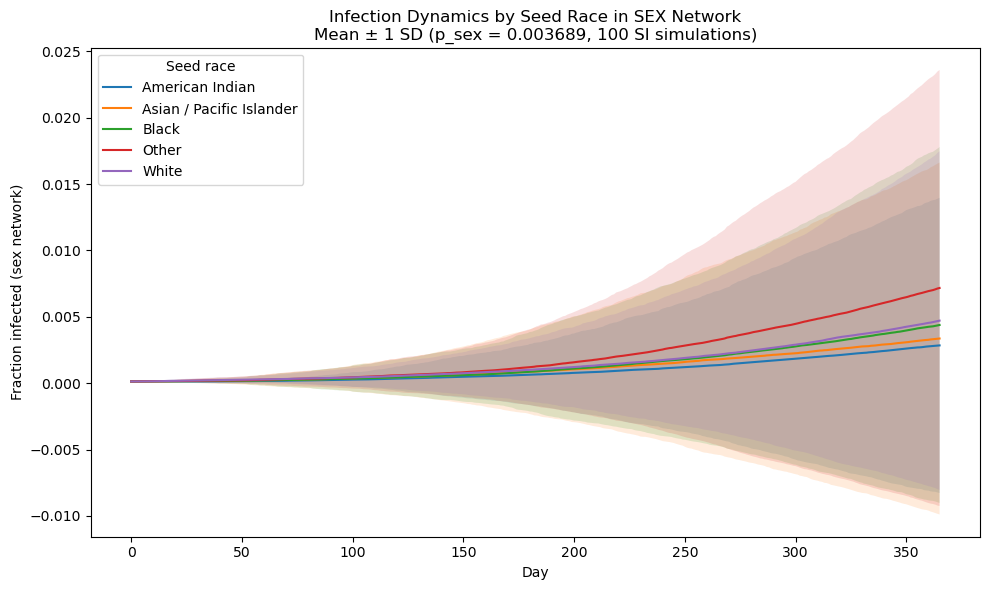

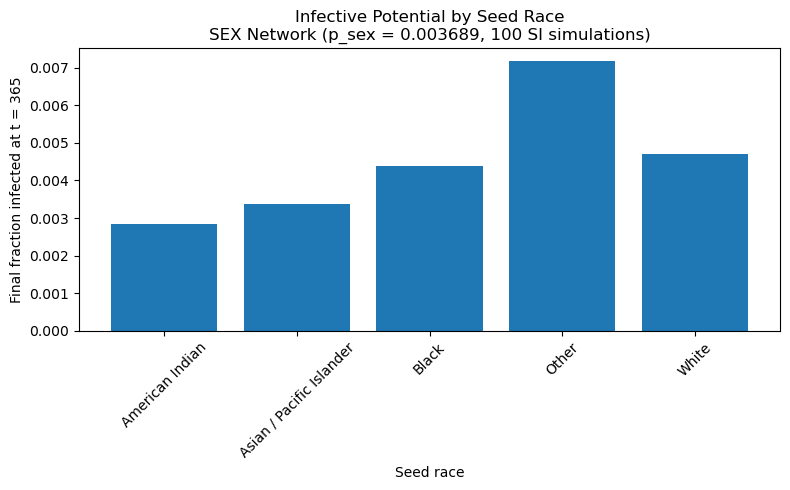

In [229]:
# ======================================================================
# SI CONTAGION ON SEX NETWORK BY RACE (using p_sex)
# ======================================================================

import random
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1. Identify race/ethnicity column in df_1_clean
# ---------------------------------------------------------------
race_candidates = [
    c for c in df_1_clean.columns
    if c.lower().startswith("race") or "ethnic" in c.lower()
]
if not race_candidates:
    raise ValueError("Could not find a race/ethnicity column in df_1_clean.")

race_col = race_candidates[0]
print(f"Using race column for SEX network: {race_col}")

# ---------------------------------------------------------------
# 2. Map numeric race codes -> labels
#    >>> Adjust to match your codebook if needed <<<
# ---------------------------------------------------------------
race_map = {
    1: "White",
    2: "Black",
    3: "American Indian",
    4: "Asian / Pacific Islander",
    5: "Other",
}

# ---------------------------------------------------------------
# 3. Build race -> node mapping for the SEX network
# ---------------------------------------------------------------
sex_nodes = set(G_sex.nodes())
race_nodes_sex = {label: set() for label in race_map.values()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in sex_nodes:
        continue

    r_code = row[race_col]
    if r_code in race_map:
        race_label = race_map[r_code]
        race_nodes_sex[race_label].add(rid)
    # ignore missing / out-of-range codes

print("\nSEX network race counts:")
for label, nodes in race_nodes_sex.items():
    print(f"  {label}: {len(nodes)}")

# ---------------------------------------------------------------
# 4. Helper: run SI with CIs on SEX network by race
# ---------------------------------------------------------------
def run_race_with_CI_sex(
    G,
    race_nodes,
    p,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    race_mean = {}
    race_std = {}

    for label, nodes in race_nodes.items():
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[SEX SI] Simulating (seed in {label}) with {len(nodes)} candidate seeds...")

        all_runs = []
        for _ in range(n_runs):
            seed = random.choice(nodes)
            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )
            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)
        race_mean[label] = arr.mean(axis=0)
        race_std[label]  = arr.std(axis=0)

    return t_range, race_mean, race_std

# ---------------------------------------------------------------
# 5. Run SI on SEX network by race
# ---------------------------------------------------------------
t_race_sex, race_mean_sex, race_std_sex = run_race_with_CI_sex(
    G_sex,
    race_nodes_sex,
    p=p_sex,
    tmax=365,
    n_runs=100,
    rng_seed=42
)

# ---------------------------------------------------------------
# 6. Plot I(t) with confidence bands (SEX network, by race)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for label in sorted(race_mean_sex.keys()):
    mean_curve = race_mean_sex[label]
    sd_curve   = race_std_sex[label]

    plt.plot(t_race_sex, mean_curve, label=label)
    plt.fill_between(
        t_race_sex,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (sex network)")
plt.title(
    "Infection Dynamics by Seed Race in SEX Network\n"
    f"Mean ± 1 SD (p_sex = {p_sex:.4g}, 100 SI simulations)"
)
plt.legend(title="Seed race")
plt.tight_layout()
plt.savefig("RaceCurve_InfectivePotentialSEX.pdf", dpi=1000)
plt.show()

# ---------------------------------------------------------------
# 7. Bar plot: infective potential by race (SEX network)
# ---------------------------------------------------------------
final_values_race_sex = {
    label: race_mean_sex[label][-1]
    for label in race_mean_sex
}

sorted_races_sex = list(sorted(final_values_race_sex.keys()))
vals_race_sex = [final_values_race_sex[label] for label in sorted_races_sex]

plt.figure(figsize=(8, 5))
plt.bar(sorted_races_sex, vals_race_sex)
plt.xlabel("Seed race")
plt.ylabel("Final fraction infected at t = 365")
plt.title(
    "Infective Potential by Seed Race\n"
    f"SEX Network (p_sex = {p_sex:.4g}, 100 SI simulations)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Race_BarGraph_InfectivePotentialSEX.pdf", dpi=1000)
plt.show()


Using race column for DRUG network: RACE

DRUG network race counts:
  White: 10
  Black: 4509
  American Indian: 5469
  Asian / Pacific Islander: 2422
  Other: 55
[DRUG SI] Simulating (seed in White) with 10 candidate seeds...
[DRUG SI] Simulating (seed in Black) with 4509 candidate seeds...
[DRUG SI] Simulating (seed in American Indian) with 5469 candidate seeds...
[DRUG SI] Simulating (seed in Asian / Pacific Islander) with 2422 candidate seeds...
[DRUG SI] Simulating (seed in Other) with 55 candidate seeds...


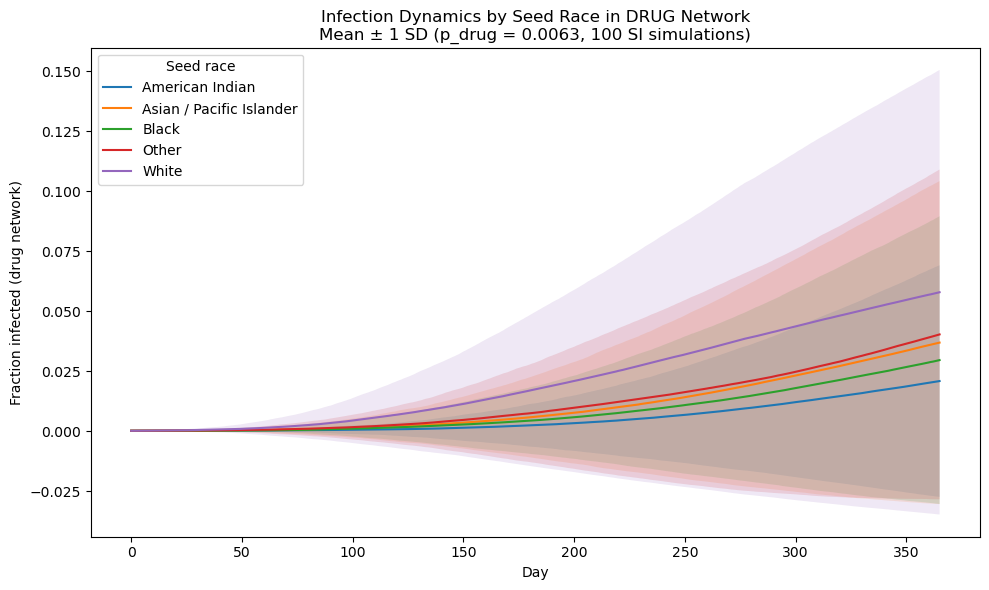

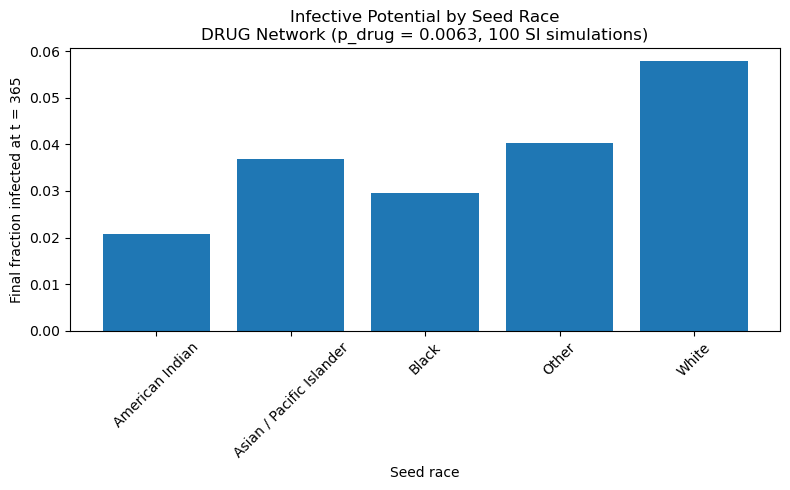

In [230]:
# ======================================================================
# SI CONTAGION ON DRUG NETWORK BY RACE (using p_drug)
# ======================================================================

import random
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1. Identify race/ethnicity column in df_1_clean
#    (reuse same race_col logic)
# ---------------------------------------------------------------
race_candidates = [
    c for c in df_1_clean.columns
    if c.lower().startswith("race") or "ethnic" in c.lower()
]
if not race_candidates:
    raise ValueError("Could not find a race/ethnicity column in df_1_clean.")

race_col = race_candidates[0]
print(f"Using race column for DRUG network: {race_col}")

# ---------------------------------------------------------------
# 2. Same race code -> label mapping
#    >>> Adjust to match your codebook if needed <<<
# ---------------------------------------------------------------
race_map = {
    1: "White",
    2: "Black",
    3: "American Indian",
    4: "Asian / Pacific Islander",
    5: "Other",
}

# ---------------------------------------------------------------
# 3. Build race -> node mapping for the DRUG network
# ---------------------------------------------------------------
drug_nodes = set(G_drug.nodes())
race_nodes_drug = {label: set() for label in race_map.values()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in drug_nodes:
        continue

    r_code = row[race_col]
    if r_code in race_map:
        race_label = race_map[r_code]
        race_nodes_drug[race_label].add(rid)
    # ignore missing / out-of-range codes

print("\nDRUG network race counts:")
for label, nodes in race_nodes_drug.items():
    print(f"  {label}: {len(nodes)}")

# ---------------------------------------------------------------
# 4. Helper: run SI with CIs on DRUG network by race
# ---------------------------------------------------------------
def run_race_with_CI_drug(
    G,
    race_nodes,
    p,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    race_mean = {}
    race_std = {}

    for label, nodes in race_nodes.items():
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[DRUG SI] Simulating (seed in {label}) with {len(nodes)} candidate seeds...")

        all_runs = []
        for _ in range(n_runs):
            seed = random.choice(nodes)
            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )
            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)
        race_mean[label] = arr.mean(axis=0)
        race_std[label]  = arr.std(axis=0)

    return t_range, race_mean, race_std

# ---------------------------------------------------------------
# 5. Run SI on DRUG network by race
# ---------------------------------------------------------------
t_race_drug, race_mean_drug, race_std_drug = run_race_with_CI_drug(
    G_drug,
    race_nodes_drug,
    p=p_drug,
    tmax=365,
    n_runs=100,
    rng_seed=42
)

# ---------------------------------------------------------------
# 6. Plot I(t) with confidence bands (DRUG network, by race)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for label in sorted(race_mean_drug.keys()):
    mean_curve = race_mean_drug[label]
    sd_curve   = race_std_drug[label]

    plt.plot(t_race_drug, mean_curve, label=label)
    plt.fill_between(
        t_race_drug,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (drug network)")
plt.title(
    "Infection Dynamics by Seed Race in DRUG Network\n"
    f"Mean ± 1 SD (p_drug = {p_drug:.4g}, 100 SI simulations)"
)
plt.legend(title="Seed race")
plt.tight_layout()
plt.savefig("RaceCurve_InfectivePotentialDRUG.pdf", dpi=1000)
plt.show()

# ---------------------------------------------------------------
# 7. Bar plot: infective potential by race (DRUG network)
# ---------------------------------------------------------------
final_values_race_drug = {
    label: race_mean_drug[label][-1]
    for label in race_mean_drug
}

sorted_races_drug = list(sorted(final_values_race_drug.keys()))
vals_race_drug = [final_values_race_drug[label] for label in sorted_races_drug]

plt.figure(figsize=(8, 5))
plt.bar(sorted_races_drug, vals_race_drug)
plt.xlabel("Seed race")
plt.ylabel("Final fraction infected at t = 365")
plt.title(
    "Infective Potential by Seed Race\n"
    f"DRUG Network (p_drug = {p_drug:.4g}, 100 SI simulations)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Race_BarGraph_InfectivePotentialDRUG.pdf", dpi=1000)
plt.show()


In [232]:
# ======================================================================
# CENTRALITY SUMMARIES ON SEX NETWORK (YOB decade, Gender, Race)
# ======================================================================

import networkx as nx
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# 0. Compute centralities on G_sex
# ---------------------------------------------------------------
print("Computing centralities on SEX network...")

deg_sex   = nx.degree_centrality(G_sex)
betw_sex  = nx.betweenness_centrality(G_sex, normalized=True)
eig_sex   = nx.eigenvector_centrality(G_sex, max_iter=1000)
close_sex = nx.closeness_centrality(G_sex)

# Helper: small function to average centralities over a set of nodes
def summarize_group_sex(group_nodes, label):
    nodes = [n for n in group_nodes if n in deg_sex]
    if not nodes:
        return None
    return {
        "Group": label,
        "N_nodes": len(nodes),
        "Degree":      float(np.mean([deg_sex[n]   for n in nodes])),
        "Closeness":   float(np.mean([close_sex[n] for n in nodes])),
        "Betweenness": float(np.mean([betw_sex[n]  for n in nodes])),
        "Eigenvector": float(np.mean([eig_sex[n]   for n in nodes])),
    }

# Convert Polars -> Pandas once
df_nodes = df_1_clean.to_pandas()

# Restrict to nodes actually in SEX network
df_nodes_sex = df_nodes[df_nodes["RID"].isin(G_sex.nodes())].copy()

# =====================================================================
# 1. BY YOB DECADE (SEX network)
# =====================================================================
df_yob = df_nodes_sex[["RID", "YOB"]].dropna()
df_yob["decade"] = (df_yob["YOB"] // 10) * 10

decade_groups_sex = {
    int(decade): set(sub["RID"].tolist())
    for decade, sub in df_yob.groupby("decade")
}

rows_decade_sex = []
for decade, nodes in sorted(decade_groups_sex.items()):
    row = summarize_group_sex(nodes, f"{decade}")
    if row:
        rows_decade_sex.append(row)

sex_decade_centrality = pd.DataFrame(rows_decade_sex)
print("\nSEX network: Avg. centrality by YOB decade")
display(sex_decade_centrality)

# =====================================================================
# 2. BY GENDER (SEX network)
#     SEX: 0 = Female, 1 = Male
# =====================================================================
gender_col = "SEX"  # if your sex column has a different name, change here

df_gender = df_nodes_sex[["RID", gender_col]].dropna()
gender_map = {0: "Female", 1: "Male"}
df_gender["gender_label"] = df_gender[gender_col].map(gender_map)
df_gender = df_gender.dropna(subset=["gender_label"])

gender_groups_sex = {
    label: set(sub["RID"].tolist())
    for label, sub in df_gender.groupby("gender_label")
}

rows_gender_sex = []
for label, nodes in sorted(gender_groups_sex.items()):
    row = summarize_group_sex(nodes, label)
    if row:
        rows_gender_sex.append(row)

sex_gender_centrality = pd.DataFrame(rows_gender_sex)
print("\nSEX network: Avg. centrality by gender")
display(sex_gender_centrality)

# =====================================================================
# 3. BY RACE (SEX network)
#     Race codes: 1 White, 2 Black, 3 AI/AN, 4 Asian/P.I., 5 Other
# =====================================================================
# auto-detect race column (or just set it explicitly if you know it)
race_candidates = [
    c for c in df_nodes_sex.columns
    if c.lower().startswith("race") or "ethnic" in c.lower()
]
if not race_candidates:
    raise ValueError("Could not find race/ethnicity column for SEX network.")
race_col = race_candidates[0]
print(f"\nUsing race column for SEX network: {race_col}")

race_map = {
    1: "White",
    2: "Black",
    3: "American Indian",
    4: "Asian / Pacific Islander",
    5: "Other",
}

df_race = df_nodes_sex[["RID", race_col]].dropna()
df_race["race_label"] = df_race[race_col].map(race_map)
df_race = df_race.dropna(subset=["race_label"])

race_groups_sex = {
    label: set(sub["RID"].tolist())
    for label, sub in df_race.groupby("race_label")
}

rows_race_sex = []
for label, nodes in sorted(race_groups_sex.items()):
    row = summarize_group_sex(nodes, label)
    if row:
        rows_race_sex.append(row)

sex_race_centrality = pd.DataFrame(rows_race_sex)
print("\nSEX network: Avg. centrality by race")
display(sex_race_centrality)

Computing centralities on SEX network...

SEX network: Avg. centrality by YOB decade


,Group,N_nodes,Degree,Closeness,Betweenness,Eigenvector
0,1900,68,0.000048,0.009903,0.000000,0.000936
1,1910,110,0.000083,0.012549,0.000030,0.004106
2,1920,283,0.000059,0.011256,0.000015,0.002746
3,1930,526,0.000071,0.012457,0.000010,0.003087
4,1940,1370,0.000121,0.013081,0.000045,0.003504
5,1950,3644,0.000135,0.010957,0.000063,0.002589
6,1960,4121,0.000135,0.010687,0.000058,0.002222
7,1970,1463,0.000088,0.008114,0.000026,0.001461
8,1980,504,0.000030,0.005276,0.000000,0.001128
9,1990,152,0.000067,0.011640,0.000008,0.002569



SEX network: Avg. centrality by gender


,Group,N_nodes,Degree,Closeness,Betweenness,Eigenvector
0,Female,5851,0.000115,0.010924,0.000046,0.002363
1,Male,4711,0.000126,0.010007,0.000050,0.002187



Using race column for SEX network: RACE

SEX network: Avg. centrality by race


,Group,N_nodes,Degree,Closeness,Betweenness,Eigenvector
0,American Indian,5469,0.000052,0.008411,0.000005,0.001494
1,Asian / Pacific Islander,2422,0.000200,0.010261,0.000096,0.003032
2,Black,4509,0.000137,0.012399,0.000065,0.002774
3,Other,55,0.000407,0.018123,0.000227,0.007302
4,White,10,0.000672,0.009674,0.000183,0.002361


In [233]:
# ======================================================================
# CENTRALITY SUMMARIES ON DRUG NETWORK (YOB decade, Gender, Race)
# ======================================================================

import networkx as nx
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# 0. Compute centralities on G_drug
# ---------------------------------------------------------------
print("Computing centralities on DRUG network...")

deg_drug   = nx.degree_centrality(G_drug)
betw_drug  = nx.betweenness_centrality(G_drug, normalized=True)
eig_drug   = nx.eigenvector_centrality(G_drug, max_iter=1000)
close_drug = nx.closeness_centrality(G_drug)

def summarize_group_drug(group_nodes, label):
    nodes = [n for n in group_nodes if n in deg_drug]
    if not nodes:
        return None
    return {
        "Group": label,
        "N_nodes": len(nodes),
        "Degree":      float(np.mean([deg_drug[n]   for n in nodes])),
        "Closeness":   float(np.mean([close_drug[n] for n in nodes])),
        "Betweenness": float(np.mean([betw_drug[n]  for n in nodes])),
        "Eigenvector": float(np.mean([eig_drug[n]   for n in nodes])),
    }

# Convert Polars -> Pandas once
df_nodes = df_1_clean.to_pandas()

# Restrict to nodes actually in DRUG network
df_nodes_drug = df_nodes[df_nodes["RID"].isin(G_drug.nodes())].copy()

# =====================================================================
# 1. BY YOB DECADE (DRUG network)
# =====================================================================
df_yob = df_nodes_drug[["RID", "YOB"]].dropna()
df_yob["decade"] = (df_yob["YOB"] // 10) * 10

decade_groups_drug = {
    int(decade): set(sub["RID"].tolist())
    for decade, sub in df_yob.groupby("decade")
}

rows_decade_drug = []
for decade, nodes in sorted(decade_groups_drug.items()):
    row = summarize_group_drug(nodes, f"{decade}")
    if row:
        rows_decade_drug.append(row)

drug_decade_centrality = pd.DataFrame(rows_decade_drug)
print("\nDRUG network: Avg. centrality by YOB decade")
display(drug_decade_centrality)

# =====================================================================
# 2. BY GENDER (DRUG network)
#     SEX: 0 = Female, 1 = Male
# =====================================================================
gender_col = "SEX"  # change if needed

df_gender = df_nodes_drug[["RID", gender_col]].dropna()
gender_map = {0: "Female", 1: "Male"}
df_gender["gender_label"] = df_gender[gender_col].map(gender_map)
df_gender = df_gender.dropna(subset=["gender_label"])

gender_groups_drug = {
    label: set(sub["RID"].tolist())
    for label, sub in df_gender.groupby("gender_label")
}

rows_gender_drug = []
for label, nodes in sorted(gender_groups_drug.items()):
    row = summarize_group_drug(nodes, label)
    if row:
        rows_gender_drug.append(row)

drug_gender_centrality = pd.DataFrame(rows_gender_drug)
print("\nDRUG network: Avg. centrality by gender")
display(drug_gender_centrality)

# =====================================================================
# 3. BY RACE (DRUG network)
#     Race codes: 1 White, 2 Black, 3 AI/AN, 4 Asian/P.I., 5 Other
# =====================================================================
race_candidates = [
    c for c in df_nodes_drug.columns
    if c.lower().startswith("race") or "ethnic" in c.lower()
]
if not race_candidates:
    raise ValueError("Could not find race/ethnicity column for DRUG network.")
race_col = race_candidates[0]
print(f"\nUsing race column for DRUG network: {race_col}")

race_map = {
    1: "White",
    2: "Black",
    3: "American Indian",
    4: "Asian / Pacific Islander",
    5: "Other",
}

df_race = df_nodes_drug[["RID", race_col]].dropna()
df_race["race_label"] = df_race[race_col].map(race_map)
df_race = df_race.dropna(subset=["race_label"])

race_groups_drug = {
    label: set(sub["RID"].tolist())
    for label, sub in df_race.groupby("race_label")
}

rows_race_drug = []
for label, nodes in sorted(race_groups_drug.items()):
    row = summarize_group_drug(nodes, label)
    if row:
        rows_race_drug.append(row)

drug_race_centrality = pd.DataFrame(rows_race_drug)
print("\nDRUG network: Avg. centrality by race")
display(drug_race_centrality)

# ---------------------------------------------------------------------
# Again: you can now do drug_decade_centrality.to_latex(...), etc.
# ---------------------------------------------------------------------


Computing centralities on DRUG network...

DRUG network: Avg. centrality by YOB decade


,Group,N_nodes,Degree,Closeness,Betweenness,Eigenvector
0,1900,68,0.000041,0.012875,0.000000,0.000668
1,1910,110,0.000055,0.010450,0.000062,0.000276
2,1920,283,0.000046,0.011493,0.000024,0.000924
3,1930,526,0.000066,0.014451,0.000017,0.001092
4,1940,1370,0.000147,0.020630,0.000107,0.001917
5,1950,3644,0.000197,0.025103,0.000142,0.002390
6,1960,4121,0.000183,0.024650,0.000114,0.002549
7,1970,1463,0.000123,0.018450,0.000062,0.001435
8,1980,504,0.000036,0.010889,0.000003,0.000698
9,1990,152,0.000065,0.019528,0.000000,0.000752



DRUG network: Avg. centrality by gender


,Group,N_nodes,Degree,Closeness,Betweenness,Eigenvector
0,Female,5851,0.000161,0.022883,0.00010,0.001942
1,Male,4711,0.000164,0.021319,0.00011,0.002153



Using race column for DRUG network: RACE

DRUG network: Avg. centrality by race


,Group,N_nodes,Degree,Closeness,Betweenness,Eigenvector
0,American Indian,5469,0.000072,0.019540,0.000016,0.000594
1,Asian / Pacific Islander,2422,0.000300,0.024429,0.000241,0.003073
2,Black,4509,0.000178,0.023557,0.000124,0.002907
3,Other,55,0.000398,0.024227,0.000360,0.002598
4,White,10,0.000685,0.014721,0.000576,0.007727
